In [1]:
import csv
import itertools
import os
import re
from collections import Counter
from collections import defaultdict
from datetime import datetime
from datetime import timedelta
from string import punctuation

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pandas.tslib import Timestamp

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.max_open_warning'] = 100
matplotlib.rcParams['lines.linewidth'] = 1.0

# Grupos

## Socios activos 2016

In [3]:
# 1.       CTA: categoría para niños y jóvenes hasta bachillerato
# 2.       CTI: categoría infantil, hasta doce años y solo es para Bogotá (blaa –biblioteca Luis Ángel Arango)
# 3.       CTB: público general (solo permite préstamo de libros)
# 4.       CTC: público en general (permite préstamo de libros y material audiovisual)
# 5.       CTF: categoría familiar, pueden acceder a los beneficios hasta tres personas del grupo familiar que se asocia
# 6.       CE1, CE2, CE2: categorías empresariales (solo para instituciones)
# 7.       CIS: categoría Inclusión Social
# 8.       CTU: categoría Universitaria
# 9.       VIP: Investigadores, préstamo de 30 materiales (libros y material audiovisual)

#      Categoría de lector: CE1 Categoría empresarial                                   218
#      Categoría de lector: CE2 Categoría empresarial 2                                   5
#      Categoría de lector: CEM Categoría Empleado/Pensionado                          1593
#      Categoría de lector: CIN Categoría Interbibliotecario                            128
#      Categoría de lector: CIP Categoría Investigador                                  351
#      Categoría de lector: CIS Categoría Inclusión Preferencial                      15974
#      Categoría de lector: CIV Categoría Investigadores                                 72
#      Categoría de lector: CML Categoría Mediador de Proyectos Culturales                2
#      Categoría de lector: CSU Categoría Sucursal                                       91
#      Categoría de lector: CTA Categoría Básica A                                    10610
#      Categoría de lector: CTB Categoría B                                            1359
#      Categoría de lector: CTC Categoría C                                             224
#      Categoría de lector: CTF Categoría familiar                                     1105
#      Categoría de lector: CTI Categoría Infantil                                     1004
#      Categoría de lector: CTU Categoría General                                     17402
#      Categoría de lector: PTE PROCESOS TÉCNICOS                                        95

In [4]:
%%time

dtypes = {
    'Sucursal': str,
    'Tratamiento': str,
    'Barrio': str,
    'Ciudad': str,
    'CATEG': str,
    'Ocupación1': str,
    'Nivel Estudio1': str,
    'Área de Estudio1': str,
    'Edad': 'category',
}

perfiles_df = pd.read_csv(
    'valores_grupos_2016.csv', header=0, dtype=dtypes)
# perfiles_df = perfiles_df.fillna('')

CPU times: user 69.3 ms, sys: 8.21 ms, total: 77.5 ms
Wall time: 76.2 ms


In [5]:
perfiles_df.shape

(50272, 9)

In [6]:
perfiles_df.head()

Sucursal Tratamiento     Barrio  Ciudad CATEG   Ocupación1 Nivel Estudio1  \
0     BLAA        OTRO  chapinero  bogota   CIN  universidad           OTRO   
1     BLAA        sra.       OTRO  bogota   CEM   pensionado           OTRO   
2     BLAA        sra.      icata  bogota   CEM     empleado    profesional   
3      ARM         sr.       OTRO    OTRO   CEM     empleado    profesional   
4     BLAA         sr.    soledad  bogota   CEM         OTRO           OTRO   

     Área de Estudio1   Edad  
0                OTRO   OTRO  
1                OTRO  50-64  
2  filosofía y letras   OTRO  
3            economía  50-64  
4                OTRO   OTRO

# Otras ciudades

In [7]:
perfiles_otras_df = perfiles_df[perfiles_df['Ciudad'] != 'bogota']

In [8]:
perfiles_otras_df.shape

(26776, 9)

In [9]:
perfiles_otras_df.head()

Sucursal Tratamiento      Barrio   Ciudad CATEG  Ocupación1 Nivel Estudio1  \
3       ARM         sr.        OTRO     OTRO   CEM    empleado    profesional   
18     BLAA         sr.    juriscol     OTRO   CEM        OTRO           OTRO   
20      IBA        sra.      claret   ibague   CIS  estudiante        técnico   
27     OTRO        OTRO  pensionado     OTRO   CEM        OTRO           OTRO   
28      PER        sra.        OTRO  pereira   CEM        OTRO           OTRO   

   Área de Estudio1   Edad  
3          economía  50-64  
18             OTRO   OTRO  
20             OTRO  30-39  
27             OTRO   OTRO  
28             OTRO  50-64

## Campos a estudiar

In [10]:
columns = sorted(dtypes)

In [11]:
for c in columns:
    cns = perfiles_otras_df[c].value_counts()
    total = cns.sum()
    otros = 0
    if 'OTRO' in cns:
        otros = cns.ix['OTRO']
    perc = '{:.2%}'.format(otros/total)
    unique = perfiles_otras_df[c].nunique()
    print(c, perc, unique)

Barrio 15.19% 2535
CATEG 0.00% 15
Ciudad 10.52% 82
Edad 10.79% 7
Nivel Estudio1 10.59% 13
Ocupación1 4.28% 17
Sucursal 0.04% 31
Tratamiento 13.17% 3
Área de Estudio1 64.77% 113


##### => Estudiar nivel de estudios (Nivel Estudio1, 10.07% sin valor) en otras ciudades por barrios.. Estudiar también área de estudios teniendo en cuenta que sólo se va a analizar el 45% de los casos (Área de Estudio1, 64.77% sin valor)  Considerar edad ('Edad) y sexo ('Tratamiento).

In [12]:
perfiles_otras_nivel_df = perfiles_otras_df[['Ciudad', 'Barrio', 'Tratamiento', 'Edad', 'Nivel Estudio1']]

In [13]:
perfiles_otras_area_df = perfiles_otras_df[['Ciudad', 'Barrio', 'Tratamiento', 'Edad', 'Área de Estudio1']]

## Eliminando valores en blanco

#### Nivel de estudios

In [14]:
perfiles_otras_nivel_df = perfiles_otras_nivel_df[
    (perfiles_otras_nivel_df['Ciudad'] != 'OTRO') &
    (perfiles_otras_nivel_df['Barrio'] != 'OTRO') &
    (perfiles_otras_nivel_df['Tratamiento'] != 'OTRO') &
    (perfiles_otras_nivel_df['Edad'] != 'OTRO') &
    (perfiles_otras_nivel_df['Nivel Estudio1'] != 'OTRO')
]

In [15]:
perfiles_otras_nivel_df.shape

(14959, 5)

In [16]:
perfiles_otras_nivel_df.head()

Ciudad              Barrio Tratamiento   Edad         Nivel Estudio1
20    ibague              claret        sra.  30-39                técnico
141   ibague  caminos del vergel         sr.    65+            profesional
213   cajica          capellania         sr.  50-64            profesional
253     chia                chia        sra.  50-64            profesional
280  pereira              centro         sr.  40-49  universitario 1 nivel

#### Área de estudios

In [17]:
perfiles_otras_area_df = perfiles_otras_area_df[
    (perfiles_otras_area_df['Ciudad'] != 'OTRO') &
    (perfiles_otras_area_df['Barrio'] != 'OTRO') &
    (perfiles_otras_area_df['Tratamiento'] != 'OTRO') &
    (perfiles_otras_area_df['Edad'] != 'OTRO') &
    (perfiles_otras_area_df['Área de Estudio1'] != 'OTRO')
]

In [18]:
perfiles_otras_area_df.shape

(5910, 5)

In [19]:
perfiles_otras_area_df.head()

Ciudad         Barrio Tratamiento   Edad    Área de Estudio1
280       pereira         centro         sr.  40-49    adm. de empresas
404          chia  tres esquinas        sra.  30-39          literatura
429  barranquilla        miramar         sr.  50-64  filosofía y letras
432         bello        florida         sr.  50-64          contaduría
458         neiva    santa lucia         sr.  40-49    ing. electrónica

## Resultados globales en las otras ciudades

#### Nivel de estudios

In [20]:
combs = [
    ('Nivel Estudio1',), # Grupos de usuarios por nivel de estudio en las otras ciudades
    ('Edad', 'Nivel Estudio1',), # Grupos de usuarios por edad y nivel de estudio en las otras ciudades
    ('Tratamiento', 'Nivel Estudio1',), # Grupos de usuarios por sexo y nivel de estudio en las otras ciudades
    ('Ciudad', 'Nivel Estudio1',), # Grupos de usuarios por ciudad y nivel de estudio en las otras ciudades
]

In [21]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = perfiles_otras_nivel_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Nivel Estudio1',) 12
('Edad', 'Nivel Estudio1') 70
('Tratamiento', 'Nivel Estudio1') 24
('Ciudad', 'Nivel Estudio1') 529
CPU times: user 5.36 s, sys: 0 ns, total: 5.36 s
Wall time: 5.35 s


COMBINATION # 1
GROUP BY: ('Nivel Estudio1',)
NUMBER OF GROUPS: 12
TOP 12 LARGEST GROUPS:


(Nivel Estudio1,)  size  total percentage
0         (básica primaria,)  4094  14959     27.37%
1              (secundaria,)  4053  14959     27.09%
2   (universitario 1 nivel,)  2169  14959     14.50%
3   (universitario 2 nivel,)  1656  14959     11.07%
4             (profesional,)  1567  14959     10.48%
5                (maestría,)   417  14959      2.79%
6                 (técnico,)   290  14959      1.94%
7               (postgrado,)   263  14959      1.76%
8             (tecnológico,)   150  14959      1.00%
9                 (ninguno,)   112  14959      0.75%
10              (doctorado,)   104  14959      0.70%
11               (graduado,)    84  14959      0.56%

COMBINATION # 2
GROUP BY: ('Edad', 'Nivel Estudio1')
NUMBER OF GROUPS: 70
TOP 12 LARGEST GROUPS:


(Edad, Nivel Estudio1)  size  total percentage
0           (17-, básica primaria)  4011  14959     26.81%
1                (17-, secundaria)  3351  14959     22.40%
2   (18-29, universitario 1 nivel)  1770  14959     11.83%
3   (18-29, universitario 2 nivel)  1319  14959      8.82%
4             (30-39, profesional)   473  14959      3.16%
5             (18-29, profesional)   456  14959      3.05%
6              (18-29, secundaria)   440  14959      2.94%
7             (50-64, profesional)   268  14959      1.79%
8   (30-39, universitario 2 nivel)   251  14959      1.68%
9             (40-49, profesional)   213  14959      1.42%
10  (30-39, universitario 1 nivel)   200  14959      1.34%
11               (30-39, maestría)   185  14959      1.24%

COMBINATION # 3
GROUP BY: ('Ciudad', 'Nivel Estudio1')
NUMBER OF GROUPS: 529
TOP 12 LARGEST GROUPS:


(Ciudad, Nivel Estudio1)  size  total percentage
0           (tunja, básica primaria)  1285  14959      8.59%
1                (neiva, secundaria)   638  14959      4.26%
2         (popayan, básica primaria)   602  14959      4.02%
3              (ipiales, secundaria)   566  14959      3.78%
4                (tunja, secundaria)   441  14959      2.95%
5             (girardot, secundaria)   410  14959      2.74%
6     (neiva, universitario 1 nivel)   323  14959      2.16%
7   (popayan, universitario 1 nivel)   317  14959      2.12%
8      (san andres, básica primaria)   298  14959      1.99%
9              (popayan, secundaria)   291  14959      1.95%
10    (tunja, universitario 2 nivel)   283  14959      1.89%
11  (popayan, universitario 2 nivel)   274  14959      1.83%

COMBINATION # 4
GROUP BY: ('Tratamiento', 'Nivel Estudio1')
NUMBER OF GROUPS: 24
TOP 12 LARGEST GROUPS:


(Tratamiento, Nivel Estudio1)  size  total percentage
0              (sra., secundaria)  2387  14959     15.96%
1         (sra., básica primaria)  2330  14959     15.58%
2          (sr., básica primaria)  1764  14959     11.79%
3               (sr., secundaria)  1666  14959     11.14%
4   (sra., universitario 1 nivel)  1150  14959      7.69%
5    (sr., universitario 1 nivel)  1019  14959      6.81%
6              (sr., profesional)   935  14959      6.25%
7    (sr., universitario 2 nivel)   855  14959      5.72%
8   (sra., universitario 2 nivel)   801  14959      5.35%
9             (sra., profesional)   632  14959      4.22%
10                (sr., maestría)   240  14959      1.60%
11               (sra., maestría)   177  14959      1.18%

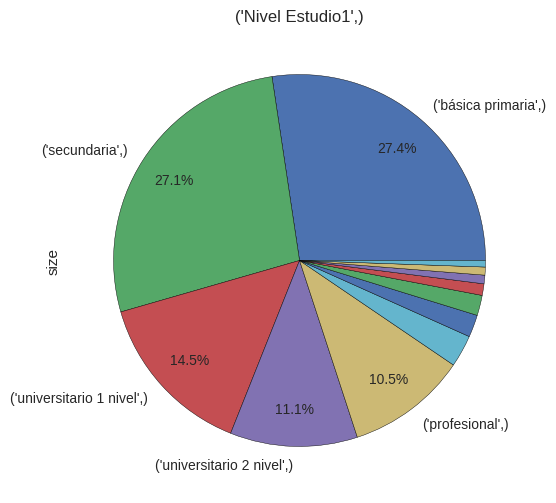

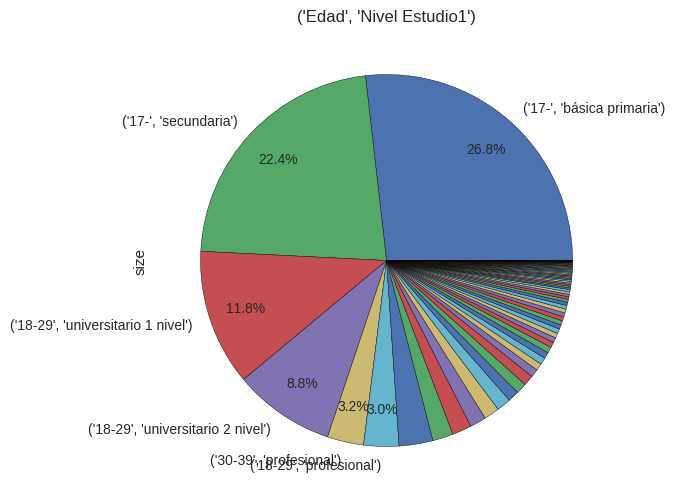

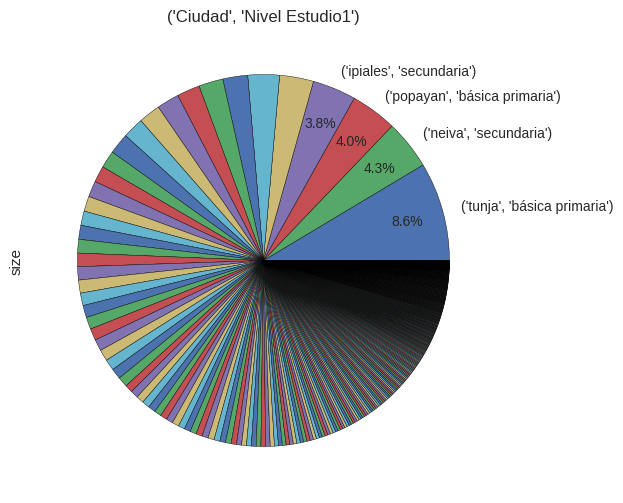

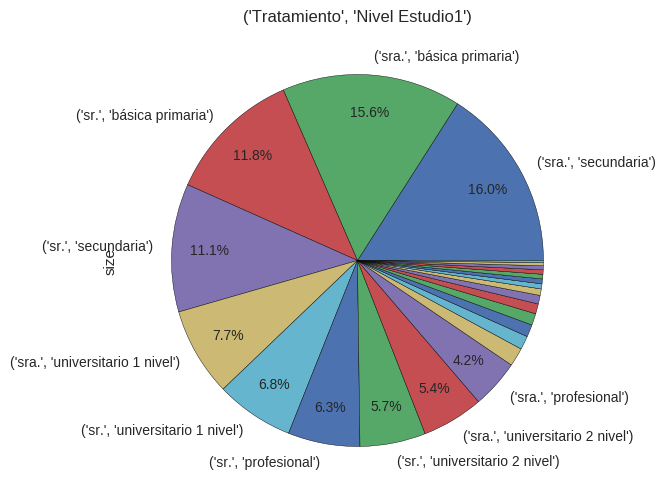

In [22]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=k)

#### Área de estudios

In [23]:
combs = [
    ('Área de Estudio1',), # Grupos de usuarios por área de estudio en las otras ciudades
    ('Tratamiento', 'Área de Estudio1'), # Grupos de usuarios por sexo y área de estudio en las otras ciudades
    ('Ciudad', 'Área de Estudio1'), # Grupos de usuarios por ciudad y área de estudio en las otras ciudades
]

In [24]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = perfiles_otras_area_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Área de Estudio1',) 110
('Tratamiento', 'Área de Estudio1') 208
('Ciudad', 'Área de Estudio1') 1308
CPU times: user 1.59 s, sys: 0 ns, total: 1.59 s
Wall time: 1.58 s


COMBINATION # 1
GROUP BY: ('Ciudad', 'Área de Estudio1')
NUMBER OF GROUPS: 1308
TOP 12 LARGEST GROUPS:


(Ciudad, Área de Estudio1)  size  total percentage
0           (ipiales, escolar)   516   5910      8.73%
1             (neiva, escolar)   171   5910      2.89%
2             (tunja, derecho)   167   5910      2.83%
3           (popayan, derecho)   112   5910      1.90%
4             (neiva, derecho)   112   5910      1.90%
5         (cartagena, derecho)   104   5910      1.76%
6        (valledupar, derecho)    86   5910      1.46%
7          (neiva, literatura)    81   5910      1.37%
8        (cartagena, historia)    67   5910      1.13%
9   (tunja, ciencias sociales)    63   5910      1.07%
10           (tunja, medicina)    57   5910      0.96%
11    (valledupar, psicología)    51   5910      0.86%

COMBINATION # 2
GROUP BY: ('Área de Estudio1',)
NUMBER OF GROUPS: 110
TOP 12 LARGEST GROUPS:


(Área de Estudio1,)  size  total percentage
0              (derecho,)   884   5910     14.96%
1              (escolar,)   719   5910     12.17%
2           (literatura,)   382   5910      6.46%
3             (historia,)   283   5910      4.79%
4           (psicología,)   242   5910      4.09%
5   (filosofía y letras,)   197   5910      3.33%
6             (medicina,)   182   5910      3.08%
7            (pedagogía,)   172   5910      2.91%
8    (ciencias sociales,)   162   5910      2.74%
9             (economía,)   162   5910      2.74%
10             (idiomas,)   148   5910      2.50%
11          (contaduría,)   137   5910      2.32%

COMBINATION # 3
GROUP BY: ('Tratamiento', 'Área de Estudio1')
NUMBER OF GROUPS: 208
TOP 12 LARGEST GROUPS:


(Tratamiento, Área de Estudio1)  size  total percentage
0                   (sr., derecho)   479   5910      8.10%
1                  (sra., derecho)   405   5910      6.85%
2                  (sra., escolar)   404   5910      6.84%
3                   (sr., escolar)   315   5910      5.33%
4               (sra., literatura)   214   5910      3.62%
5                  (sr., historia)   183   5910      3.10%
6               (sra., psicología)   169   5910      2.86%
7                (sr., literatura)   168   5910      2.84%
8        (sr., filosofía y letras)   142   5910      2.40%
9                (sra., pedagogía)   135   5910      2.28%
10                 (sr., economía)   103   5910      1.74%
11                 (sr., medicina)   102   5910      1.73%

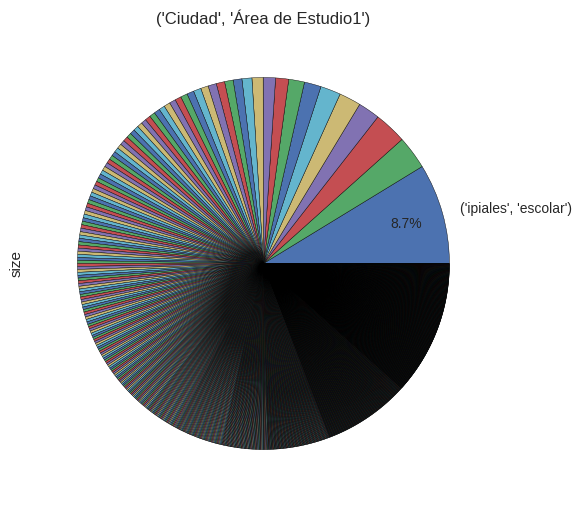

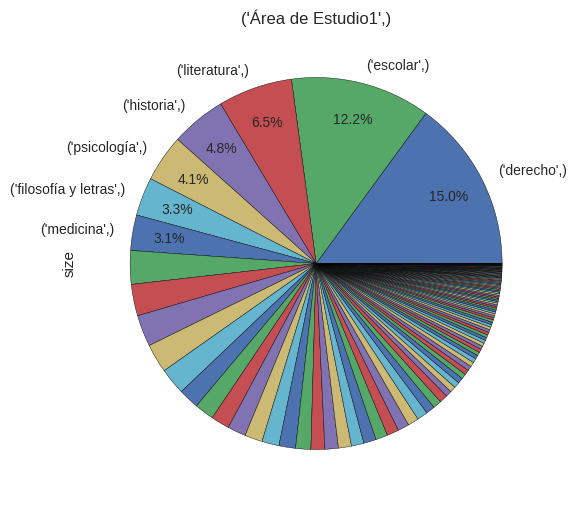

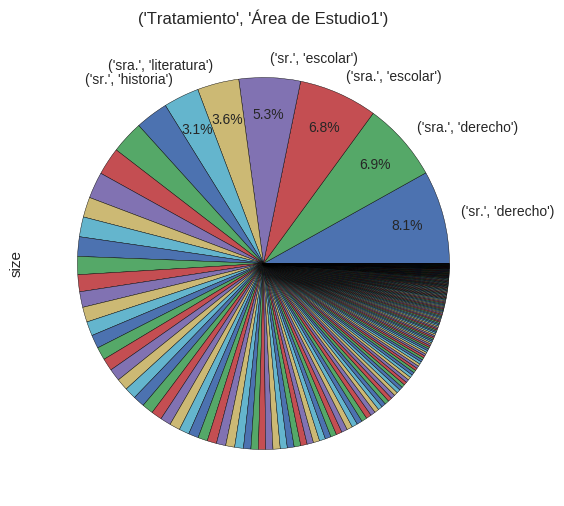

In [25]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=k)

## Resultados por ciudades

In [26]:
ciudades_counter_df = perfiles_otras_df[perfiles_otras_df['Ciudad'] != 'OTRO']['Ciudad'].value_counts()

In [27]:
ciudades_counter_df

tunja            2970
ibague           2309
popayan          2033
neiva            1787
pereira          1494
manizales        1140
ipiales          1020
girardot          910
cartagena         732
san andres        684
valledupar        651
florencia         607
armenia           495
leticia           491
quibdo            467
santa marta       436
sincelejo         428
bucaramanga       381
pasca             365
dosquebradas      362
honda             345
buenaventura      335
soacha            324
villavicencio     302
cali              273
barranquilla      250
riohacha          242
medellin          223
cucuta            210
monteria          196
                 ... 
envigado           23
cota               23
circasia           21
aipe               19
ricaurte           18
tabio              17
sibate             17
yaguara            17
villavieja         16
baraya             16
rivera             16
paipa              16
motavita           15
tenjo              15
salento   

## Top 15

In [28]:
ciudades_counter_df.head(15)

tunja         2970
ibague        2309
popayan       2033
neiva         1787
pereira       1494
manizales     1140
ipiales       1020
girardot       910
cartagena      732
san andres     684
valledupar     651
florencia      607
armenia        495
leticia        491
quibdo         467
Name: Ciudad, dtype: int64

### tunja

In [29]:
b = 'tunja'

#### Nivel de estudios

In [30]:
otra_ciudad_df = perfiles_otras_nivel_df[perfiles_otras_nivel_df['Ciudad'] == b]

In [31]:
combs = [
    ('Nivel Estudio1',), # Grupos de usuarios por nivel de estudio en la ciudad
    ('Edad', 'Nivel Estudio1'), # Grupos de usuarios por edad y nivel de estudio en la ciudad
    ('Tratamiento', 'Nivel Estudio1'), # Grupos de usuarios por sexo y nivel de estudio en la ciudad
]

In [32]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Nivel Estudio1',) 12
('Edad', 'Nivel Estudio1') 53
('Tratamiento', 'Nivel Estudio1') 23
CPU times: user 809 ms, sys: 0 ns, total: 809 ms
Wall time: 804 ms


COMBINATION # 1
GROUP BY: ('Nivel Estudio1',)
NUMBER OF GROUPS: 12
TOP 12 LARGEST GROUPS:


(Nivel Estudio1,)  size  total percentage
0         (básica primaria,)  1285   2725     47.16%
1              (secundaria,)   441   2725     16.18%
2   (universitario 2 nivel,)   283   2725     10.39%
3   (universitario 1 nivel,)   225   2725      8.26%
4             (profesional,)   208   2725      7.63%
5                (maestría,)    89   2725      3.27%
6               (postgrado,)    76   2725      2.79%
7                 (técnico,)    48   2725      1.76%
8             (tecnológico,)    34   2725      1.25%
9                 (ninguno,)    19   2725      0.70%
10              (doctorado,)    15   2725      0.55%
11               (graduado,)     2   2725      0.07%

COMBINATION # 2
GROUP BY: ('Edad', 'Nivel Estudio1')
NUMBER OF GROUPS: 53
TOP 12 LARGEST GROUPS:


(Edad, Nivel Estudio1)  size  total percentage
0           (17-, básica primaria)  1265   2725     46.42%
1                (17-, secundaria)   324   2725     11.89%
2   (18-29, universitario 2 nivel)   248   2725      9.10%
3   (18-29, universitario 1 nivel)   201   2725      7.38%
4             (18-29, profesional)    86   2725      3.16%
5             (30-39, profesional)    61   2725      2.24%
6              (18-29, secundaria)    47   2725      1.72%
7                (30-39, maestría)    42   2725      1.54%
8              (30-39, secundaria)    38   2725      1.39%
9             (40-49, profesional)    31   2725      1.14%
10  (30-39, universitario 2 nivel)    29   2725      1.06%
11              (18-29, postgrado)    27   2725      0.99%

COMBINATION # 3
GROUP BY: ('Tratamiento', 'Nivel Estudio1')
NUMBER OF GROUPS: 23
TOP 12 LARGEST GROUPS:


(Tratamiento, Nivel Estudio1)  size  total percentage
0         (sra., básica primaria)   798   2725     29.28%
1          (sr., básica primaria)   487   2725     17.87%
2              (sra., secundaria)   272   2725      9.98%
3               (sr., secundaria)   169   2725      6.20%
4    (sr., universitario 2 nivel)   150   2725      5.50%
5   (sra., universitario 2 nivel)   133   2725      4.88%
6   (sra., universitario 1 nivel)   130   2725      4.77%
7             (sra., profesional)   117   2725      4.29%
8    (sr., universitario 1 nivel)    95   2725      3.49%
9              (sr., profesional)    91   2725      3.34%
10               (sra., maestría)    50   2725      1.83%
11              (sra., postgrado)    47   2725      1.72%

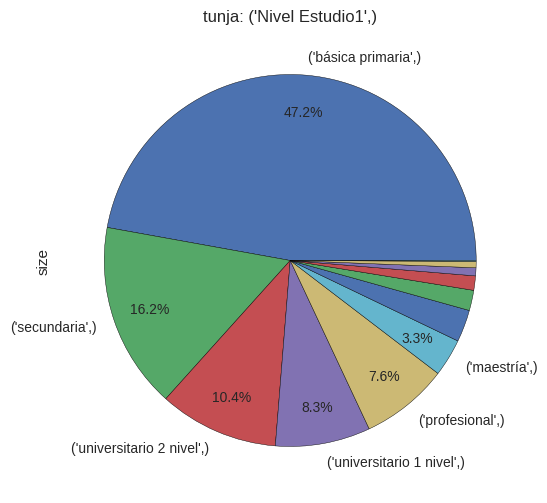

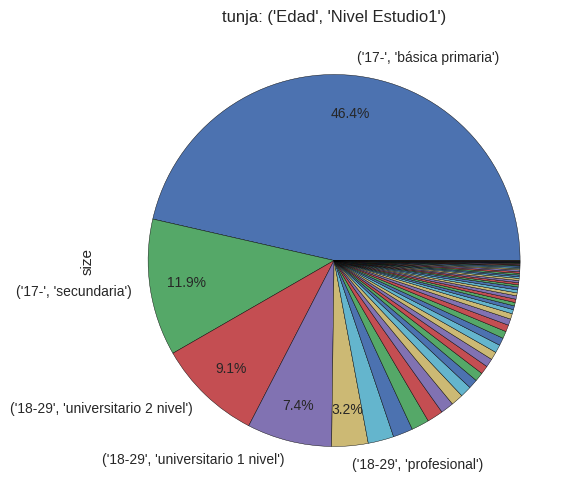

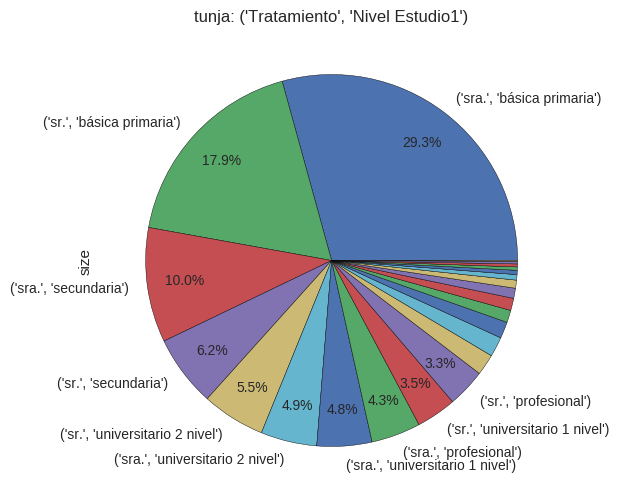

In [33]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

#### Área de estudios

In [34]:
otra_ciudad_df = perfiles_otras_area_df[perfiles_otras_area_df['Ciudad'] == b]

In [35]:
combs = [
    ('Área de Estudio1',), # Grupos de usuarios por área de estudio en la ciudad
    ('Tratamiento', 'Área de Estudio1'), # Grupos de usuarios por sexo y área de estudio en la ciudad
]

In [36]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Área de Estudio1',) 82
('Tratamiento', 'Área de Estudio1') 128
CPU times: user 170 ms, sys: 0 ns, total: 170 ms
Wall time: 169 ms


COMBINATION # 1
GROUP BY: ('Área de Estudio1',)
NUMBER OF GROUPS: 82
TOP 12 LARGEST GROUPS:


(Área de Estudio1,)  size  total percentage
0              (derecho,)   167    905     18.45%
1    (ciencias sociales,)    63    905      6.96%
2             (medicina,)    57    905      6.30%
3           (psicología,)    43    905      4.75%
4              (idiomas,)    39    905      4.31%
5             (economía,)    30    905      3.31%
6             (biología,)    26    905      2.87%
7           (contaduría,)    25    905      2.76%
8         (arquitectura,)    24    905      2.65%
9           (ing. civil,)    24    905      2.65%
10  (filosofía y letras,)    22    905      2.43%
11           (pedagogía,)    22    905      2.43%

COMBINATION # 2
GROUP BY: ('Tratamiento', 'Área de Estudio1')
NUMBER OF GROUPS: 128
TOP 12 LARGEST GROUPS:


(Tratamiento, Área de Estudio1)  size  total percentage
0                  (sra., derecho)    88    905      9.72%
1                   (sr., derecho)    79    905      8.73%
2         (sr., ciencias sociales)    37    905      4.09%
3                  (sr., medicina)    32    905      3.54%
4               (sra., psicología)    29    905      3.20%
5        (sra., ciencias sociales)    26    905      2.87%
6                  (sra., idiomas)    25    905      2.76%
7                 (sra., medicina)    25    905      2.76%
8                 (sra., biología)    20    905      2.21%
9                (sra., pedagogía)    18    905      1.99%
10               (sr., ing. civil)    18    905      1.99%
11              (sra., preescolar)    17    905      1.88%

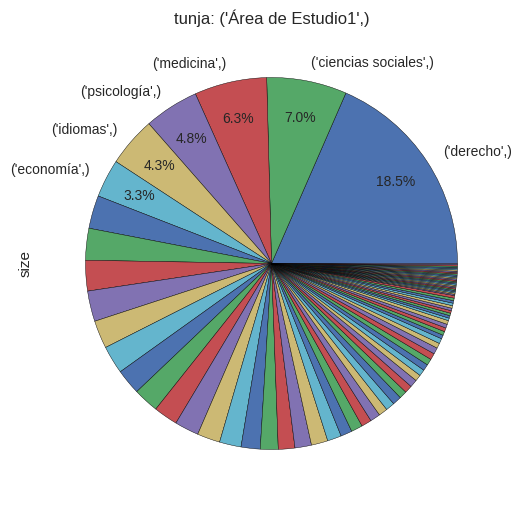

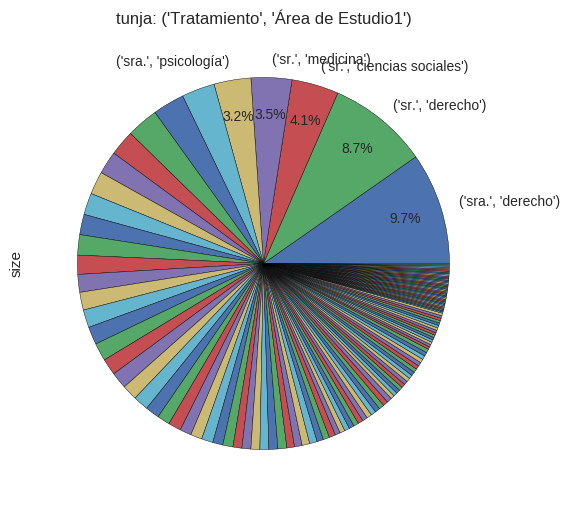

In [37]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

In [38]:
ciudades_counter_df.head(15)

tunja         2970
ibague        2309
popayan       2033
neiva         1787
pereira       1494
manizales     1140
ipiales       1020
girardot       910
cartagena      732
san andres     684
valledupar     651
florencia      607
armenia        495
leticia        491
quibdo         467
Name: Ciudad, dtype: int64

### ibague

In [39]:
b = 'ibague'

#### Nivel de estudios

In [40]:
otra_ciudad_df = perfiles_otras_nivel_df[perfiles_otras_nivel_df['Ciudad'] == b]

In [41]:
combs = [
    ('Nivel Estudio1',), # Grupos de usuarios por nivel de estudio en la ciudad
    ('Edad', 'Nivel Estudio1'), # Grupos de usuarios por edad y nivel de estudio en la ciudad
    ('Tratamiento', 'Nivel Estudio1'), # Grupos de usuarios por sexo y nivel de estudio en la ciudad
]

In [42]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Nivel Estudio1',) 12
('Edad', 'Nivel Estudio1') 39
('Tratamiento', 'Nivel Estudio1') 23
CPU times: user 147 ms, sys: 75 µs, total: 147 ms
Wall time: 146 ms


COMBINATION # 1
GROUP BY: ('Nivel Estudio1',)
NUMBER OF GROUPS: 12
TOP 12 LARGEST GROUPS:


(Nivel Estudio1,)  size  total percentage
0              (secundaria,)   177    524     33.78%
1         (básica primaria,)   100    524     19.08%
2   (universitario 1 nivel,)    80    524     15.27%
3   (universitario 2 nivel,)    61    524     11.64%
4             (profesional,)    50    524      9.54%
5                (maestría,)    27    524      5.15%
6                 (técnico,)     8    524      1.53%
7               (postgrado,)     8    524      1.53%
8               (doctorado,)     5    524      0.95%
9             (tecnológico,)     4    524      0.76%
10               (graduado,)     2    524      0.38%
11                (ninguno,)     2    524      0.38%

COMBINATION # 2
GROUP BY: ('Edad', 'Nivel Estudio1')
NUMBER OF GROUPS: 39
TOP 12 LARGEST GROUPS:


(Edad, Nivel Estudio1)  size  total percentage
0                (17-, secundaria)   151    524     28.82%
1           (17-, básica primaria)    99    524     18.89%
2   (18-29, universitario 1 nivel)    64    524     12.21%
3   (18-29, universitario 2 nivel)    51    524      9.73%
4              (18-29, secundaria)    21    524      4.01%
5             (30-39, profesional)    16    524      3.05%
6             (50-64, profesional)    12    524      2.29%
7                (30-39, maestría)    11    524      2.10%
8             (40-49, profesional)    10    524      1.91%
9   (30-39, universitario 1 nivel)     9    524      1.72%
10  (30-39, universitario 2 nivel)     8    524      1.53%
11    (17-, universitario 1 nivel)     7    524      1.34%

COMBINATION # 3
GROUP BY: ('Tratamiento', 'Nivel Estudio1')
NUMBER OF GROUPS: 23
TOP 12 LARGEST GROUPS:


(Tratamiento, Nivel Estudio1)  size  total percentage
0              (sra., secundaria)   106    524     20.23%
1               (sr., secundaria)    71    524     13.55%
2         (sra., básica primaria)    58    524     11.07%
3          (sr., básica primaria)    42    524      8.02%
4    (sr., universitario 1 nivel)    40    524      7.63%
5   (sra., universitario 1 nivel)    40    524      7.63%
6              (sr., profesional)    38    524      7.25%
7    (sr., universitario 2 nivel)    33    524      6.30%
8   (sra., universitario 2 nivel)    28    524      5.34%
9                 (sr., maestría)    18    524      3.44%
10            (sra., profesional)    12    524      2.29%
11               (sra., maestría)     9    524      1.72%

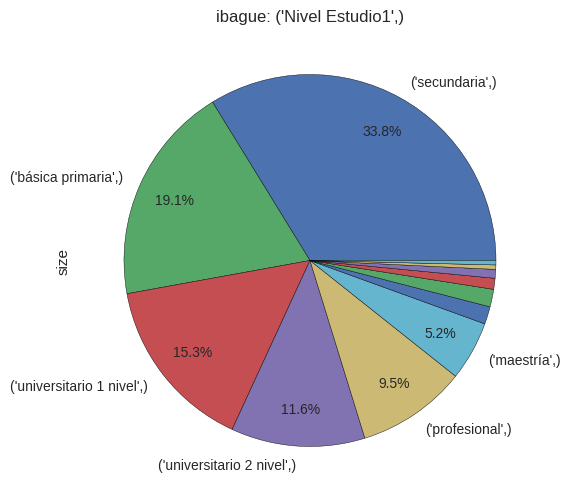

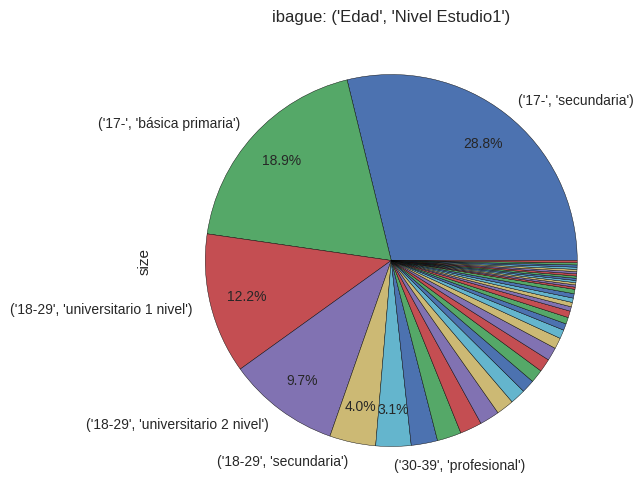

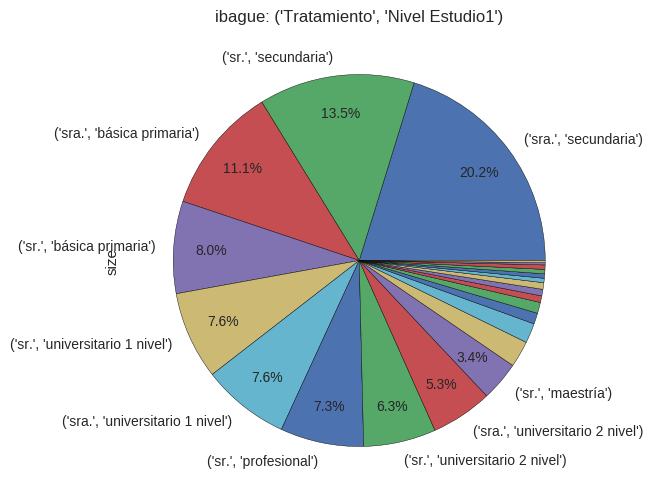

In [43]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

#### Área de estudios

In [44]:
otra_ciudad_df = perfiles_otras_area_df[perfiles_otras_area_df['Ciudad'] == b]

In [45]:
combs = [
    ('Área de Estudio1',), # Grupos de usuarios por área de estudio en la ciudad
    ('Tratamiento', 'Área de Estudio1'), # Grupos de usuarios por sexo y área de estudio en la ciudad
]

In [46]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Área de Estudio1',) 38
('Tratamiento', 'Área de Estudio1') 55
CPU times: user 27.7 ms, sys: 0 ns, total: 27.7 ms
Wall time: 26.7 ms


COMBINATION # 1
GROUP BY: ('Área de Estudio1',)
NUMBER OF GROUPS: 38
TOP 12 LARGEST GROUPS:


(Área de Estudio1,)  size  total percentage
0               (derecho,)    19    124     15.32%
1            (literatura,)    11    124      8.87%
2              (historia,)    11    124      8.87%
3     (ciencias sociales,)     6    124      4.84%
4              (economía,)     5    124      4.03%
5            (sociología,)     5    124      4.03%
6            (contaduría,)     5    124      4.03%
7            (ing. civil,)     5    124      4.03%
8              (medicina,)     4    124      3.23%
9    (ciencias políticas,)     4    124      3.23%
10  (comunicación social,)     3    124      2.42%
11          (veterinaria,)     3    124      2.42%

COMBINATION # 2
GROUP BY: ('Tratamiento', 'Área de Estudio1')
NUMBER OF GROUPS: 55
TOP 12 LARGEST GROUPS:


(Tratamiento, Área de Estudio1)  size  total percentage
0                   (sr., derecho)    10    124      8.06%
1                  (sra., derecho)     9    124      7.26%
2                  (sr., historia)     8    124      6.45%
3                (sr., literatura)     6    124      4.84%
4               (sra., literatura)     5    124      4.03%
5               (sra., ing. civil)     4    124      3.23%
6               (sra., sociología)     4    124      3.23%
7                  (sr., economía)     4    124      3.23%
8         (sr., ciencias sociales)     4    124      3.23%
9                  (sr., medicina)     3    124      2.42%
10       (sr., ciencias políticas)     3    124      2.42%
11                (sra., historia)     3    124      2.42%

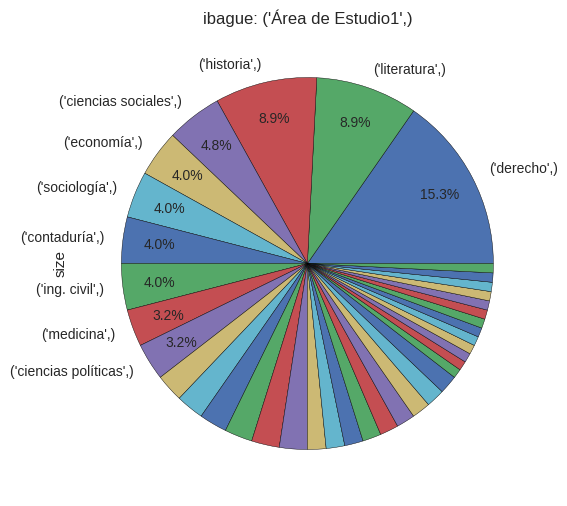

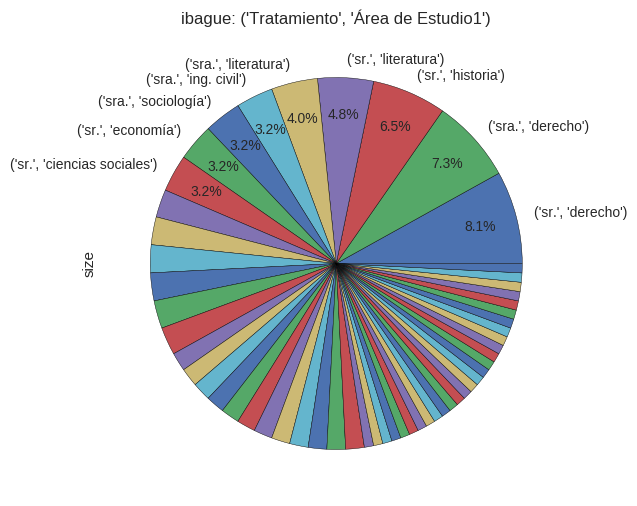

In [47]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

In [48]:
ciudades_counter_df.head(15)

tunja         2970
ibague        2309
popayan       2033
neiva         1787
pereira       1494
manizales     1140
ipiales       1020
girardot       910
cartagena      732
san andres     684
valledupar     651
florencia      607
armenia        495
leticia        491
quibdo         467
Name: Ciudad, dtype: int64

### popayan

In [49]:
b = 'popayan'

#### Nivel de estudios

In [50]:
otra_ciudad_df = perfiles_otras_nivel_df[perfiles_otras_nivel_df['Ciudad'] == b]

In [51]:
combs = [
    ('Nivel Estudio1',), # Grupos de usuarios por nivel de estudio en la ciudad
    ('Edad', 'Nivel Estudio1'), # Grupos de usuarios por edad y nivel de estudio en la ciudad
    ('Tratamiento', 'Nivel Estudio1'), # Grupos de usuarios por sexo y nivel de estudio en la ciudad
]

In [52]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Nivel Estudio1',) 12
('Edad', 'Nivel Estudio1') 50
('Tratamiento', 'Nivel Estudio1') 23
CPU times: user 471 ms, sys: 0 ns, total: 471 ms
Wall time: 469 ms


COMBINATION # 1
GROUP BY: ('Nivel Estudio1',)
NUMBER OF GROUPS: 12
TOP 12 LARGEST GROUPS:


(Nivel Estudio1,)  size  total percentage
0         (básica primaria,)   602   1703     35.35%
1   (universitario 1 nivel,)   317   1703     18.61%
2              (secundaria,)   291   1703     17.09%
3   (universitario 2 nivel,)   274   1703     16.09%
4             (profesional,)   131   1703      7.69%
5                 (técnico,)    28   1703      1.64%
6                (maestría,)    20   1703      1.17%
7             (tecnológico,)    19   1703      1.12%
8               (doctorado,)     7   1703      0.41%
9               (postgrado,)     7   1703      0.41%
10                (ninguno,)     6   1703      0.35%
11               (graduado,)     1   1703      0.06%

COMBINATION # 2
GROUP BY: ('Edad', 'Nivel Estudio1')
NUMBER OF GROUPS: 50
TOP 12 LARGEST GROUPS:


(Edad, Nivel Estudio1)  size  total percentage
0           (17-, básica primaria)   591   1703     34.70%
1   (18-29, universitario 1 nivel)   252   1703     14.80%
2                (17-, secundaria)   228   1703     13.39%
3   (18-29, universitario 2 nivel)   217   1703     12.74%
4              (18-29, secundaria)    50   1703      2.94%
5   (30-39, universitario 2 nivel)    49   1703      2.88%
6   (30-39, universitario 1 nivel)    41   1703      2.41%
7             (30-39, profesional)    39   1703      2.29%
8             (50-64, profesional)    34   1703      2.00%
9             (18-29, profesional)    22   1703      1.29%
10            (40-49, profesional)    21   1703      1.23%
11    (17-, universitario 1 nivel)    17   1703      1.00%

COMBINATION # 3
GROUP BY: ('Tratamiento', 'Nivel Estudio1')
NUMBER OF GROUPS: 23
TOP 12 LARGEST GROUPS:


(Tratamiento, Nivel Estudio1)  size  total percentage
0         (sra., básica primaria)   340   1703     19.96%
1          (sr., básica primaria)   262   1703     15.38%
2              (sra., secundaria)   199   1703     11.69%
3   (sra., universitario 1 nivel)   161   1703      9.45%
4    (sr., universitario 1 nivel)   156   1703      9.16%
5   (sra., universitario 2 nivel)   150   1703      8.81%
6    (sr., universitario 2 nivel)   124   1703      7.28%
7               (sr., secundaria)    92   1703      5.40%
8              (sr., profesional)    72   1703      4.23%
9             (sra., profesional)    59   1703      3.46%
10                 (sr., técnico)    15   1703      0.88%
11                (sra., técnico)    13   1703      0.76%

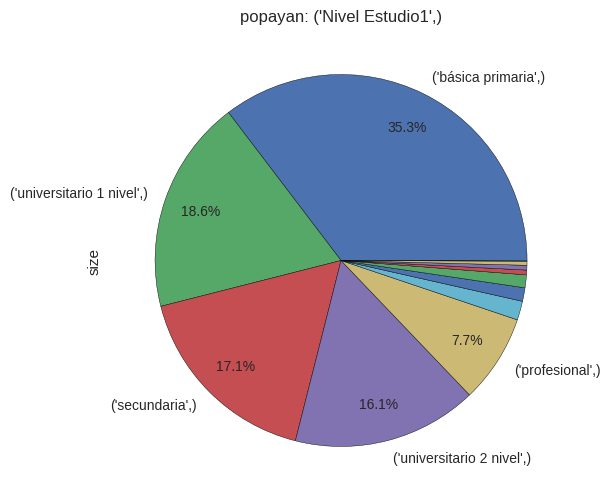

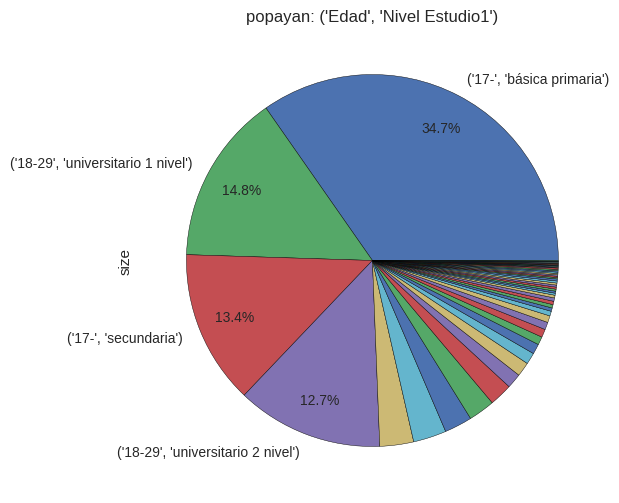

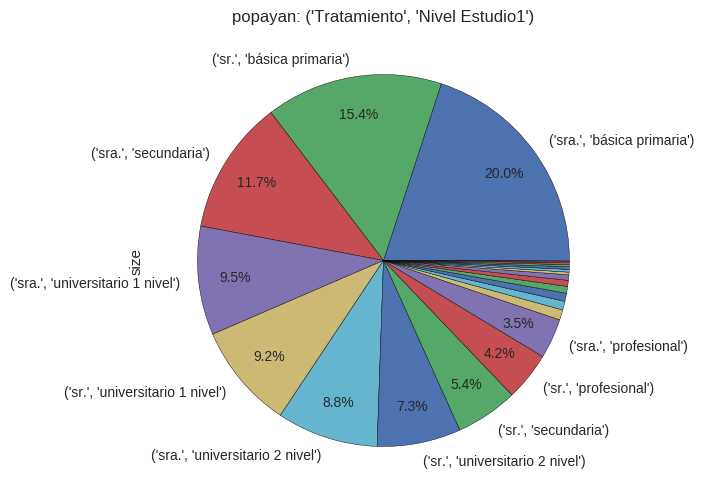

In [53]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

#### Área de estudios

In [54]:
otra_ciudad_df = perfiles_otras_area_df[perfiles_otras_area_df['Ciudad'] == b]

In [55]:
combs = [
    ('Área de Estudio1',), # Grupos de usuarios por área de estudio en la ciudad
    ('Tratamiento', 'Área de Estudio1'), # Grupos de usuarios por sexo y área de estudio en la ciudad
]

In [56]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Área de Estudio1',) 51
('Tratamiento', 'Área de Estudio1') 84
CPU times: user 105 ms, sys: 47 µs, total: 105 ms
Wall time: 105 ms


COMBINATION # 1
GROUP BY: ('Área de Estudio1',)
NUMBER OF GROUPS: 51
TOP 12 LARGEST GROUPS:


(Área de Estudio1,)  size  total percentage
0              (derecho,)   112    542     20.66%
1           (literatura,)    43    542      7.93%
2   (ciencias políticas,)    36    542      6.64%
3             (historia,)    28    542      5.17%
4         (antropología,)    23    542      4.24%
5          (matemáticas,)    20    542      3.69%
6           (psicología,)    20    542      3.69%
7             (economía,)    18    542      3.32%
8             (medicina,)    17    542      3.14%
9   (filosofía y letras,)    16    542      2.95%
10          (contaduría,)    15    542      2.77%
11            (biología,)    14    542      2.58%

COMBINATION # 2
GROUP BY: ('Tratamiento', 'Área de Estudio1')
NUMBER OF GROUPS: 84
TOP 12 LARGEST GROUPS:


(Tratamiento, Área de Estudio1)  size  total percentage
0                  (sra., derecho)    64    542     11.81%
1                   (sr., derecho)    48    542      8.86%
2               (sra., literatura)    25    542      4.61%
3        (sr., ciencias políticas)    19    542      3.51%
4                (sr., literatura)    18    542      3.32%
5       (sra., ciencias políticas)    17    542      3.14%
6               (sra., psicología)    17    542      3.14%
7               (sr., matemáticas)    15    542      2.77%
8                 (sra., historia)    14    542      2.58%
9                  (sr., historia)    14    542      2.58%
10               (sr., ing. civil)    12    542      2.21%
11            (sra., antropología)    12    542      2.21%

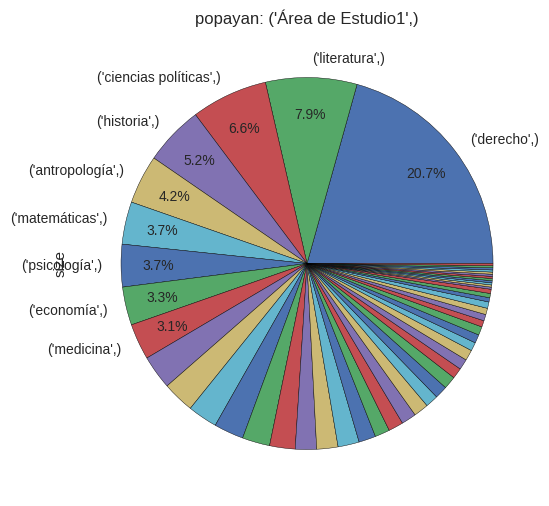

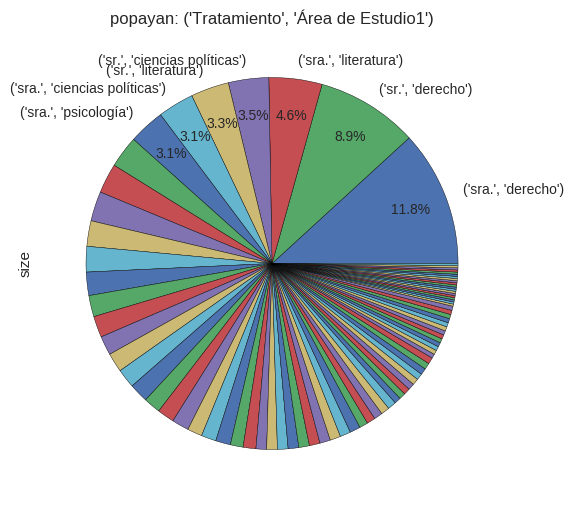

In [57]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

In [58]:
ciudades_counter_df.head(15)

tunja         2970
ibague        2309
popayan       2033
neiva         1787
pereira       1494
manizales     1140
ipiales       1020
girardot       910
cartagena      732
san andres     684
valledupar     651
florencia      607
armenia        495
leticia        491
quibdo         467
Name: Ciudad, dtype: int64

### neiva

In [59]:
b = 'neiva'

#### Nivel de estudios

In [60]:
otra_ciudad_df = perfiles_otras_nivel_df[perfiles_otras_nivel_df['Ciudad'] == b]

In [61]:
combs = [
    ('Nivel Estudio1',), # Grupos de usuarios por nivel de estudio en la ciudad
    ('Edad', 'Nivel Estudio1'), # Grupos de usuarios por edad y nivel de estudio en la ciudad
    ('Tratamiento', 'Nivel Estudio1'), # Grupos de usuarios por sexo y nivel de estudio en la ciudad
]

In [62]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Nivel Estudio1',) 12
('Edad', 'Nivel Estudio1') 53
('Tratamiento', 'Nivel Estudio1') 24
CPU times: user 433 ms, sys: 2.25 ms, total: 435 ms
Wall time: 434 ms


COMBINATION # 1
GROUP BY: ('Nivel Estudio1',)
NUMBER OF GROUPS: 12
TOP 12 LARGEST GROUPS:


(Nivel Estudio1,)  size  total percentage
0              (secundaria,)   638   1592     40.08%
1   (universitario 1 nivel,)   323   1592     20.29%
2         (básica primaria,)   212   1592     13.32%
3   (universitario 2 nivel,)   175   1592     10.99%
4             (profesional,)   144   1592      9.05%
5                (maestría,)    33   1592      2.07%
6                 (técnico,)    24   1592      1.51%
7               (postgrado,)    17   1592      1.07%
8             (tecnológico,)     9   1592      0.57%
9                (graduado,)     7   1592      0.44%
10              (doctorado,)     6   1592      0.38%
11                (ninguno,)     4   1592      0.25%

COMBINATION # 2
GROUP BY: ('Edad', 'Nivel Estudio1')
NUMBER OF GROUPS: 53
TOP 12 LARGEST GROUPS:


(Edad, Nivel Estudio1)  size  total percentage
0                (17-, secundaria)   521   1592     32.73%
1   (18-29, universitario 1 nivel)   266   1592     16.71%
2           (17-, básica primaria)   208   1592     13.07%
3   (18-29, universitario 2 nivel)   140   1592      8.79%
4              (18-29, secundaria)    85   1592      5.34%
5             (18-29, profesional)    48   1592      3.02%
6             (30-39, profesional)    40   1592      2.51%
7     (17-, universitario 1 nivel)    35   1592      2.20%
8             (50-64, profesional)    32   1592      2.01%
9   (30-39, universitario 1 nivel)    19   1592      1.19%
10  (30-39, universitario 2 nivel)    18   1592      1.13%
11              (65+, profesional)    14   1592      0.88%

COMBINATION # 3
GROUP BY: ('Tratamiento', 'Nivel Estudio1')
NUMBER OF GROUPS: 24
TOP 12 LARGEST GROUPS:


(Tratamiento, Nivel Estudio1)  size  total percentage
0              (sra., secundaria)   333   1592     20.92%
1               (sr., secundaria)   305   1592     19.16%
2   (sra., universitario 1 nivel)   170   1592     10.68%
3    (sr., universitario 1 nivel)   153   1592      9.61%
4          (sr., básica primaria)   107   1592      6.72%
5    (sr., universitario 2 nivel)   105   1592      6.60%
6         (sra., básica primaria)   105   1592      6.60%
7              (sr., profesional)    90   1592      5.65%
8   (sra., universitario 2 nivel)    70   1592      4.40%
9             (sra., profesional)    54   1592      3.39%
10                (sr., maestría)    20   1592      1.26%
11                (sra., técnico)    13   1592      0.82%

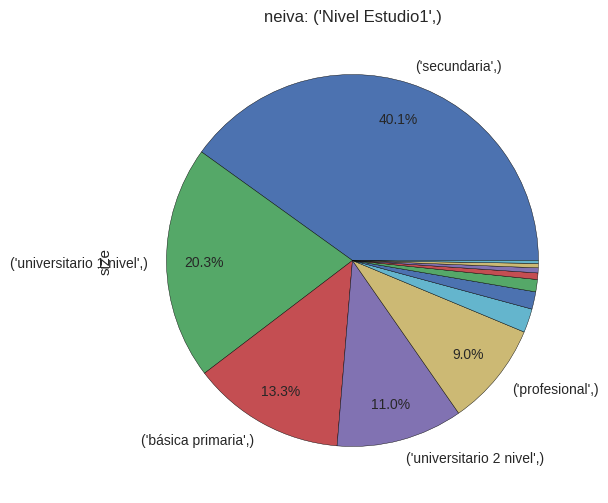

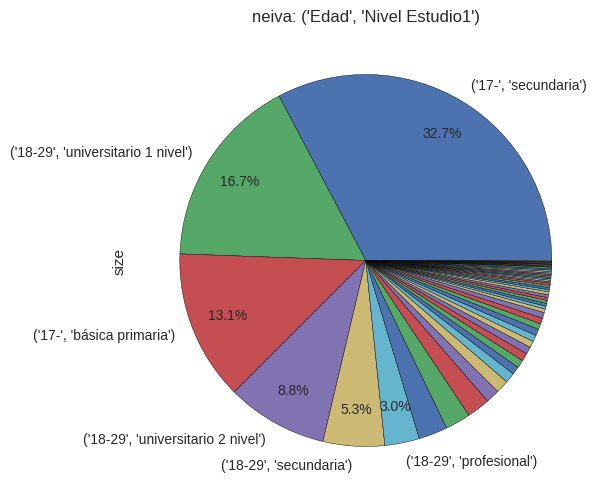

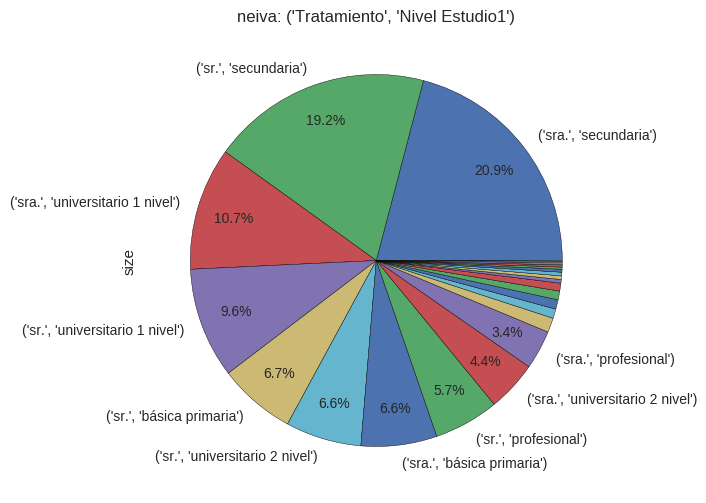

In [63]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

#### Área de estudios

In [64]:
otra_ciudad_df = perfiles_otras_area_df[perfiles_otras_area_df['Ciudad'] == b]

In [65]:
combs = [
    ('Área de Estudio1',), # Grupos de usuarios por área de estudio en la ciudad
    ('Tratamiento', 'Área de Estudio1'), # Grupos de usuarios por sexo y área de estudio en la ciudad
]

In [66]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Área de Estudio1',) 67
('Tratamiento', 'Área de Estudio1') 111
CPU times: user 164 ms, sys: 0 ns, total: 164 ms
Wall time: 162 ms


COMBINATION # 1
GROUP BY: ('Área de Estudio1',)
NUMBER OF GROUPS: 67
TOP 12 LARGEST GROUPS:


(Área de Estudio1,)  size  total percentage
0              (escolar,)   171    883     19.37%
1              (derecho,)   112    883     12.68%
2           (literatura,)    81    883      9.17%
3            (pedagogía,)    39    883      4.42%
4           (enfermería,)    35    883      3.96%
5              (idiomas,)    32    883      3.62%
6           (psicología,)    32    883      3.62%
7   (ciencias políticas,)    29    883      3.28%
8             (economía,)    26    883      2.94%
9             (medicina,)    25    883      2.83%
10    (adm. de empresas,)    19    883      2.15%
11          (contaduría,)    18    883      2.04%

COMBINATION # 2
GROUP BY: ('Tratamiento', 'Área de Estudio1')
NUMBER OF GROUPS: 111
TOP 12 LARGEST GROUPS:


(Tratamiento, Área de Estudio1)  size  total percentage
0                  (sra., escolar)    94    883     10.65%
1                   (sr., escolar)    77    883      8.72%
2                   (sr., derecho)    72    883      8.15%
3               (sra., literatura)    45    883      5.10%
4                  (sra., derecho)    40    883      4.53%
5                (sr., literatura)    36    883      4.08%
6                (sra., pedagogía)    35    883      3.96%
7                  (sr., economía)    21    883      2.38%
8               (sra., psicología)    20    883      2.27%
9               (sra., enfermería)    20    883      2.27%
10       (sr., ciencias políticas)    18    883      2.04%
11                 (sra., idiomas)    16    883      1.81%

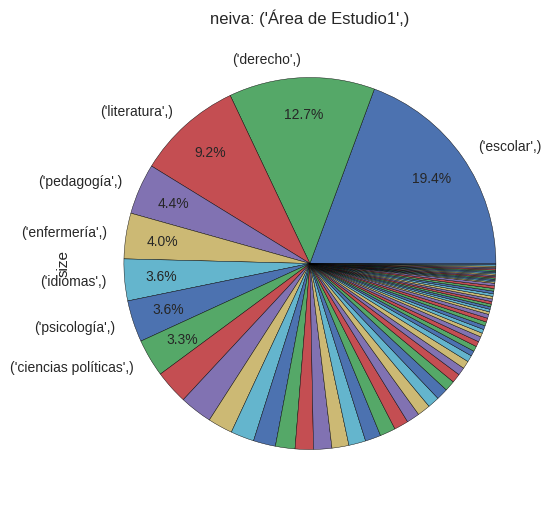

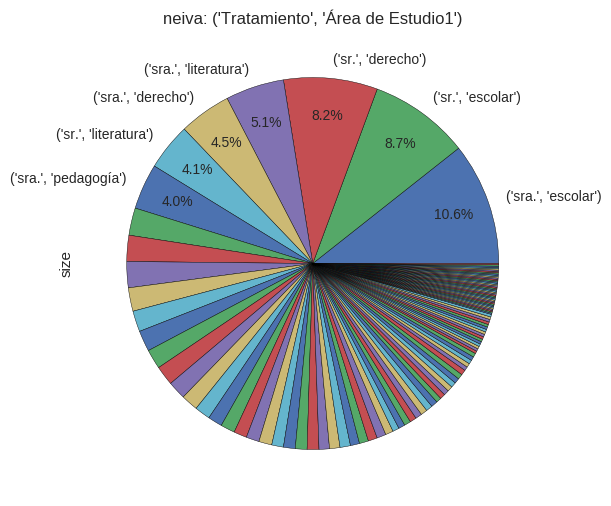

In [67]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

In [68]:
ciudades_counter_df.head(15)

tunja         2970
ibague        2309
popayan       2033
neiva         1787
pereira       1494
manizales     1140
ipiales       1020
girardot       910
cartagena      732
san andres     684
valledupar     651
florencia      607
armenia        495
leticia        491
quibdo         467
Name: Ciudad, dtype: int64

### pereira

In [69]:
b = 'pereira'

#### Nivel de estudios

In [70]:
otra_ciudad_df = perfiles_otras_nivel_df[perfiles_otras_nivel_df['Ciudad'] == b]

In [71]:
combs = [
    ('Nivel Estudio1',), # Grupos de usuarios por nivel de estudio en la ciudad
    ('Edad', 'Nivel Estudio1'), # Grupos de usuarios por edad y nivel de estudio en la ciudad
    ('Tratamiento', 'Nivel Estudio1'), # Grupos de usuarios por sexo y nivel de estudio en la ciudad
]

In [72]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Nivel Estudio1',) 11
('Edad', 'Nivel Estudio1') 42
('Tratamiento', 'Nivel Estudio1') 21
CPU times: user 205 ms, sys: 0 ns, total: 205 ms
Wall time: 203 ms


COMBINATION # 1
GROUP BY: ('Nivel Estudio1',)
NUMBER OF GROUPS: 11
TOP 12 LARGEST GROUPS:


(Nivel Estudio1,)  size  total percentage
0              (secundaria,)   271    738     36.72%
1         (básica primaria,)   169    738     22.90%
2   (universitario 1 nivel,)   153    738     20.73%
3             (profesional,)    63    738      8.54%
4   (universitario 2 nivel,)    29    738      3.93%
5                (maestría,)    24    738      3.25%
6                 (técnico,)    13    738      1.76%
7               (postgrado,)     8    738      1.08%
8             (tecnológico,)     4    738      0.54%
9               (doctorado,)     3    738      0.41%
10               (graduado,)     1    738      0.14%

COMBINATION # 2
GROUP BY: ('Edad', 'Nivel Estudio1')
NUMBER OF GROUPS: 42
TOP 12 LARGEST GROUPS:


(Edad, Nivel Estudio1)  size  total percentage
0                (17-, secundaria)   242    738     32.79%
1           (17-, básica primaria)   168    738     22.76%
2   (18-29, universitario 1 nivel)   121    738     16.40%
3              (18-29, secundaria)    25    738      3.39%
4   (30-39, universitario 1 nivel)    20    738      2.71%
5             (30-39, profesional)    20    738      2.71%
6   (18-29, universitario 2 nivel)    20    738      2.71%
7             (50-64, profesional)    16    738      2.17%
8                (30-39, maestría)    11    738      1.49%
9             (18-29, profesional)    11    738      1.49%
10              (65+, profesional)    11    738      1.49%
11  (30-39, universitario 2 nivel)     6    738      0.81%

COMBINATION # 3
GROUP BY: ('Tratamiento', 'Nivel Estudio1')
NUMBER OF GROUPS: 21
TOP 12 LARGEST GROUPS:


(Tratamiento, Nivel Estudio1)  size  total percentage
0              (sra., secundaria)   183    738     24.80%
1         (sra., básica primaria)   124    738     16.80%
2               (sr., secundaria)    88    738     11.92%
3    (sr., universitario 1 nivel)    85    738     11.52%
4   (sra., universitario 1 nivel)    68    738      9.21%
5          (sr., básica primaria)    45    738      6.10%
6              (sr., profesional)    44    738      5.96%
7             (sra., profesional)    19    738      2.57%
8                 (sr., maestría)    16    738      2.17%
9    (sr., universitario 2 nivel)    16    738      2.17%
10  (sra., universitario 2 nivel)    13    738      1.76%
11                 (sr., técnico)     8    738      1.08%

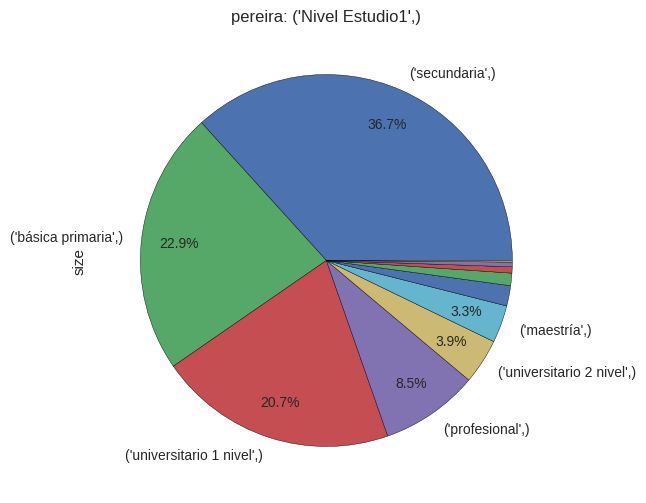

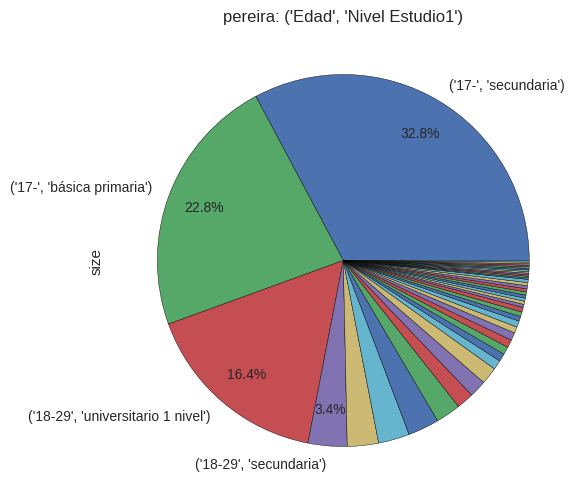

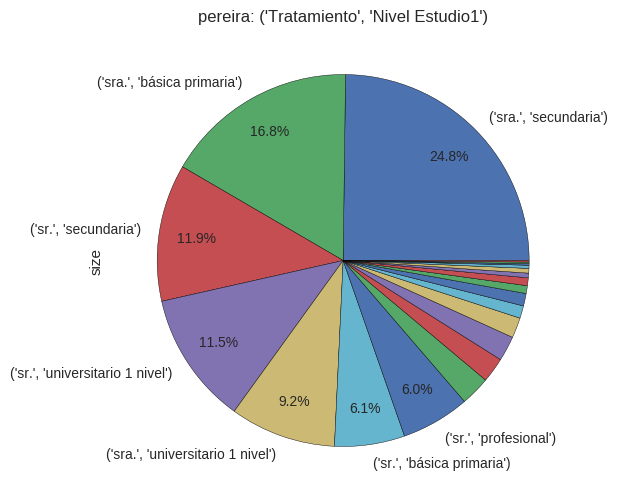

In [73]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

#### Área de estudios

In [74]:
otra_ciudad_df = perfiles_otras_area_df[perfiles_otras_area_df['Ciudad'] == b]

In [75]:
combs = [
    ('Área de Estudio1',), # Grupos de usuarios por área de estudio en la ciudad
    ('Tratamiento', 'Área de Estudio1'), # Grupos de usuarios por sexo y área de estudio en la ciudad
]

In [76]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Área de Estudio1',) 38
('Tratamiento', 'Área de Estudio1') 51
CPU times: user 33.8 ms, sys: 0 ns, total: 33.8 ms
Wall time: 32 ms


COMBINATION # 1
GROUP BY: ('Área de Estudio1',)
NUMBER OF GROUPS: 38
TOP 12 LARGEST GROUPS:


(Área de Estudio1,)  size  total percentage
0           (literatura,)    16    118     13.56%
1   (filosofía y letras,)    12    118     10.17%
2              (derecho,)    11    118      9.32%
3           (psicología,)     8    118      6.78%
4             (medicina,)     6    118      5.08%
5            (pedagogía,)     5    118      4.24%
6      (artes plásticas,)     4    118      3.39%
7           (sociología,)     4    118      3.39%
8             (historia,)     4    118      3.39%
9     (adm. de empresas,)     3    118      2.54%
10             (idiomas,)     3    118      2.54%
11            (economía,)     3    118      2.54%

COMBINATION # 2
GROUP BY: ('Tratamiento', 'Área de Estudio1')
NUMBER OF GROUPS: 51
TOP 12 LARGEST GROUPS:


(Tratamiento, Área de Estudio1)  size  total percentage
0        (sr., filosofía y letras)    11    118      9.32%
1                (sr., literatura)    10    118      8.47%
2                   (sr., derecho)     7    118      5.93%
3               (sra., literatura)     6    118      5.08%
4                (sr., psicología)     5    118      4.24%
5                (sra., pedagogía)     5    118      4.24%
6                  (sr., medicina)     4    118      3.39%
7                  (sra., derecho)     4    118      3.39%
8                  (sr., historia)     4    118      3.39%
9          (sr., ing. electrónica)     3    118      2.54%
10         (sra., artes plásticas)     3    118      2.54%
11               (sr., sociología)     3    118      2.54%

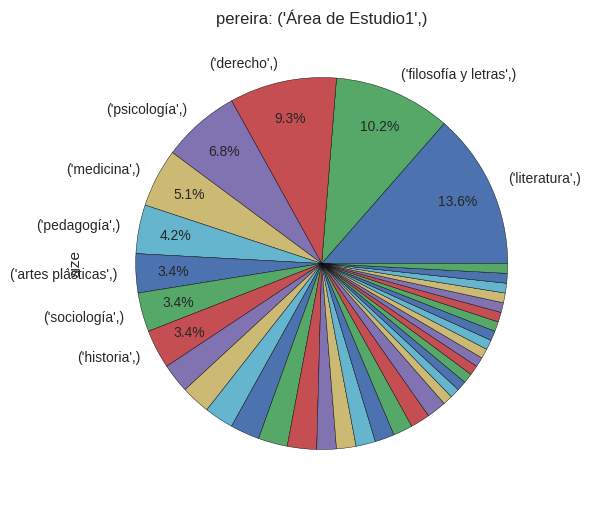

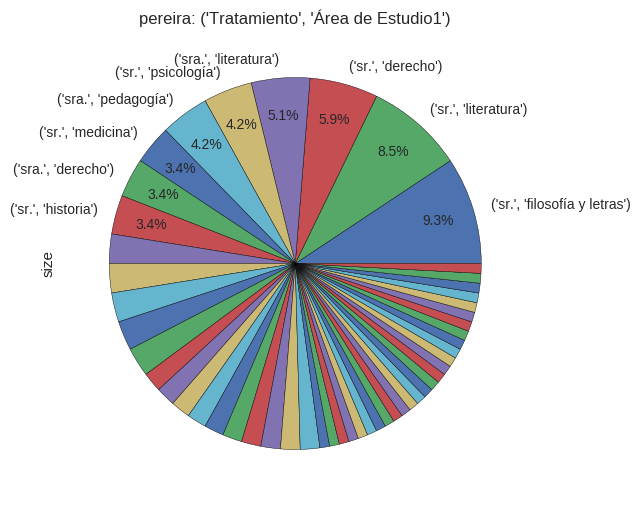

In [77]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

In [78]:
ciudades_counter_df.head(15)

tunja         2970
ibague        2309
popayan       2033
neiva         1787
pereira       1494
manizales     1140
ipiales       1020
girardot       910
cartagena      732
san andres     684
valledupar     651
florencia      607
armenia        495
leticia        491
quibdo         467
Name: Ciudad, dtype: int64

### manizales

In [79]:
b = 'manizales'

#### Nivel de estudios

In [80]:
otra_ciudad_df = perfiles_otras_nivel_df[perfiles_otras_nivel_df['Ciudad'] == b]

In [81]:
combs = [
    ('Nivel Estudio1',), # Grupos de usuarios por nivel de estudio en la ciudad
    ('Edad', 'Nivel Estudio1'), # Grupos de usuarios por edad y nivel de estudio en la ciudad
    ('Tratamiento', 'Nivel Estudio1'), # Grupos de usuarios por sexo y nivel de estudio en la ciudad
]

In [82]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Nivel Estudio1',) 11
('Edad', 'Nivel Estudio1') 26
('Tratamiento', 'Nivel Estudio1') 18
CPU times: user 26.6 ms, sys: 0 ns, total: 26.6 ms
Wall time: 25.3 ms


COMBINATION # 1
GROUP BY: ('Nivel Estudio1',)
NUMBER OF GROUPS: 11
TOP 12 LARGEST GROUPS:


(Nivel Estudio1,)  size  total percentage
0   (universitario 1 nivel,)    25     78     32.05%
1             (profesional,)    21     78     26.92%
2   (universitario 2 nivel,)     8     78     10.26%
3                (maestría,)     8     78     10.26%
4              (secundaria,)     4     78      5.13%
5               (doctorado,)     3     78      3.85%
6         (básica primaria,)     3     78      3.85%
7               (postgrado,)     2     78      2.56%
8             (tecnológico,)     2     78      2.56%
9                (graduado,)     1     78      1.28%
10                (técnico,)     1     78      1.28%

COMBINATION # 2
GROUP BY: ('Edad', 'Nivel Estudio1')
NUMBER OF GROUPS: 26
TOP 12 LARGEST GROUPS:


(Edad, Nivel Estudio1)  size  total percentage
0   (18-29, universitario 1 nivel)    17     78     21.79%
1             (50-64, profesional)     8     78     10.26%
2             (30-39, profesional)     6     78      7.69%
3   (30-39, universitario 1 nivel)     6     78      7.69%
4   (30-39, universitario 2 nivel)     4     78      5.13%
5                (30-39, maestría)     4     78      5.13%
6               (65+, profesional)     4     78      5.13%
7             (40-49, profesional)     3     78      3.85%
8                (17-, secundaria)     3     78      3.85%
9               (50-64, doctorado)     3     78      3.85%
10  (40-49, universitario 2 nivel)     2     78      2.56%
11               (40-49, maestría)     2     78      2.56%

COMBINATION # 3
GROUP BY: ('Tratamiento', 'Nivel Estudio1')
NUMBER OF GROUPS: 18
TOP 12 LARGEST GROUPS:


(Tratamiento, Nivel Estudio1)  size  total percentage
0    (sr., universitario 1 nivel)    18     78     23.08%
1              (sr., profesional)    18     78     23.08%
2                 (sr., maestría)     8     78     10.26%
3   (sra., universitario 1 nivel)     7     78      8.97%
4    (sr., universitario 2 nivel)     5     78      6.41%
5   (sra., universitario 2 nivel)     3     78      3.85%
6             (sra., profesional)     3     78      3.85%
7                (sr., doctorado)     3     78      3.85%
8               (sr., secundaria)     2     78      2.56%
9          (sr., básica primaria)     2     78      2.56%
10             (sra., secundaria)     2     78      2.56%
11                (sra., técnico)     1     78      1.28%

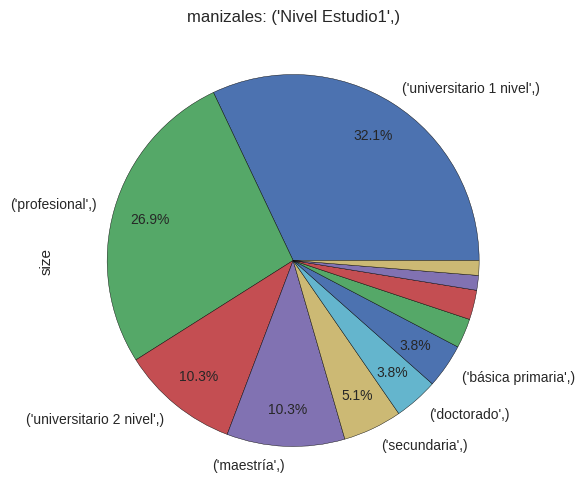

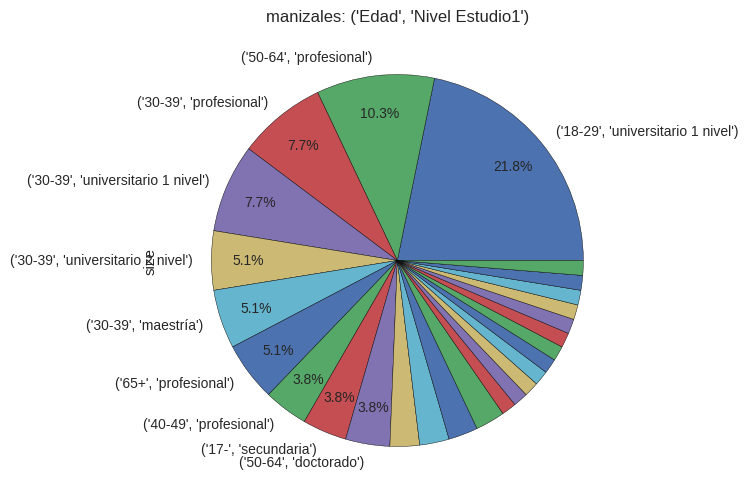

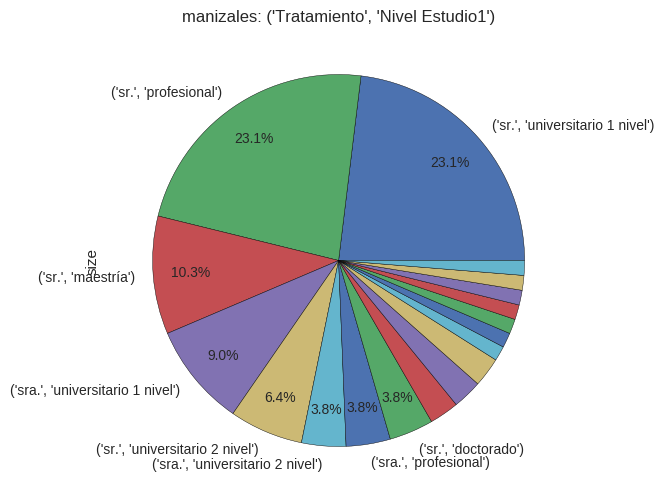

In [83]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

#### Área de estudios

In [84]:
otra_ciudad_df = perfiles_otras_area_df[perfiles_otras_area_df['Ciudad'] == b]

In [85]:
combs = [
    ('Área de Estudio1',), # Grupos de usuarios por área de estudio en la ciudad
    ('Tratamiento', 'Área de Estudio1'), # Grupos de usuarios por sexo y área de estudio en la ciudad
]

In [86]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Área de Estudio1',) 24
('Tratamiento', 'Área de Estudio1') 29
CPU times: user 12.5 ms, sys: 126 µs, total: 12.6 ms
Wall time: 12.3 ms


COMBINATION # 1
GROUP BY: ('Área de Estudio1',)
NUMBER OF GROUPS: 24
TOP 12 LARGEST GROUPS:


(Área de Estudio1,)  size  total percentage
0    (filosofía y letras,)    11     53     20.75%
1               (derecho,)     6     53     11.32%
2            (literatura,)     5     53      9.43%
3              (medicina,)     3     53      5.66%
4            (sociología,)     3     53      5.66%
5          (antropología,)     3     53      5.66%
6              (historia,)     3     53      5.66%
7       (artes plásticas,)     2     53      3.77%
8            (ing. civil,)     2     53      3.77%
9   (comunicación social,)     1     53      1.89%
10     (adm. de empresas,)     1     53      1.89%
11      (electromecánica,)     1     53      1.89%

COMBINATION # 2
GROUP BY: ('Tratamiento', 'Área de Estudio1')
NUMBER OF GROUPS: 29
TOP 12 LARGEST GROUPS:


(Tratamiento, Área de Estudio1)  size  total percentage
0        (sr., filosofía y letras)    10     53     18.87%
1                (sr., literatura)     5     53      9.43%
2                   (sr., derecho)     4     53      7.55%
3                (sr., sociología)     3     53      5.66%
4                  (sr., historia)     3     53      5.66%
5                (sr., ing. civil)     2     53      3.77%
6                  (sra., derecho)     2     53      3.77%
7              (sr., antropología)     2     53      3.77%
8                  (sr., medicina)     2     53      3.77%
9                 (sr., geografía)     1     53      1.89%
10               (sr., topografia)     1     53      1.89%
11     (sra., dibujo publicitario)     1     53      1.89%

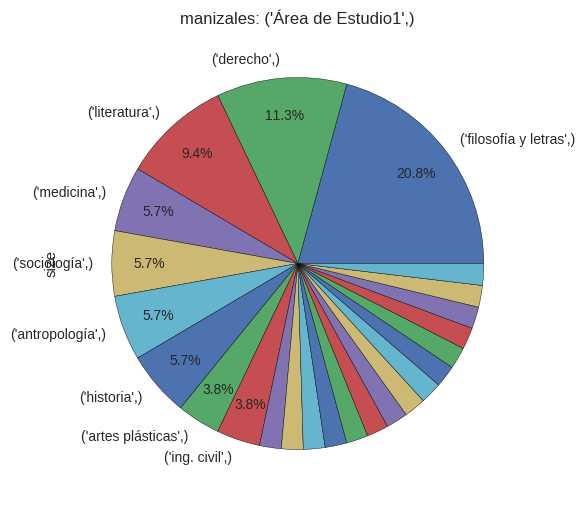

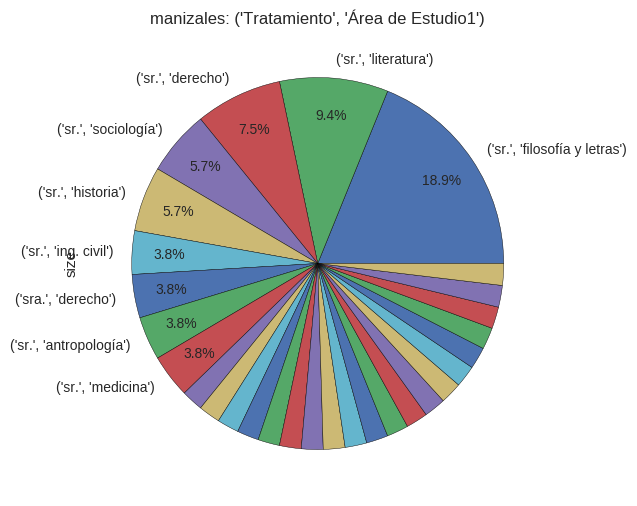

In [87]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

In [88]:
ciudades_counter_df.head(15)

tunja         2970
ibague        2309
popayan       2033
neiva         1787
pereira       1494
manizales     1140
ipiales       1020
girardot       910
cartagena      732
san andres     684
valledupar     651
florencia      607
armenia        495
leticia        491
quibdo         467
Name: Ciudad, dtype: int64

### ipiales

In [89]:
b = 'ipiales'

#### Nivel de estudios

In [90]:
otra_ciudad_df = perfiles_otras_nivel_df[perfiles_otras_nivel_df['Ciudad'] == b]

In [91]:
combs = [
    ('Nivel Estudio1',), # Grupos de usuarios por nivel de estudio en la ciudad
    ('Edad', 'Nivel Estudio1'), # Grupos de usuarios por edad y nivel de estudio en la ciudad
    ('Tratamiento', 'Nivel Estudio1'), # Grupos de usuarios por sexo y nivel de estudio en la ciudad
]

In [92]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Nivel Estudio1',) 12
('Edad', 'Nivel Estudio1') 32
('Tratamiento', 'Nivel Estudio1') 20
CPU times: user 253 ms, sys: 1.41 ms, total: 254 ms
Wall time: 253 ms


COMBINATION # 1
GROUP BY: ('Nivel Estudio1',)
NUMBER OF GROUPS: 12
TOP 12 LARGEST GROUPS:


(Nivel Estudio1,)  size  total percentage
0              (secundaria,)   566    904     62.61%
1         (básica primaria,)   196    904     21.68%
2             (profesional,)    81    904      8.96%
3   (universitario 1 nivel,)    19    904      2.10%
4   (universitario 2 nivel,)    16    904      1.77%
5                 (ninguno,)     8    904      0.88%
6               (postgrado,)     6    904      0.66%
7                 (técnico,)     4    904      0.44%
8                (maestría,)     3    904      0.33%
9             (tecnológico,)     3    904      0.33%
10               (graduado,)     1    904      0.11%
11              (doctorado,)     1    904      0.11%

COMBINATION # 2
GROUP BY: ('Edad', 'Nivel Estudio1')
NUMBER OF GROUPS: 32
TOP 12 LARGEST GROUPS:


(Edad, Nivel Estudio1)  size  total percentage
0                (17-, secundaria)   505    904     55.86%
1           (17-, básica primaria)   193    904     21.35%
2              (18-29, secundaria)    53    904      5.86%
3             (18-29, profesional)    43    904      4.76%
4             (30-39, profesional)    21    904      2.32%
5   (18-29, universitario 1 nivel)    16    904      1.77%
6   (18-29, universitario 2 nivel)    14    904      1.55%
7                   (17-, ninguno)     8    904      0.88%
8             (50-64, profesional)     6    904      0.66%
9             (40-49, profesional)     5    904      0.55%
10             (50-64, secundaria)     4    904      0.44%
11              (17-, profesional)     3    904      0.33%

COMBINATION # 3
GROUP BY: ('Tratamiento', 'Nivel Estudio1')
NUMBER OF GROUPS: 20
TOP 12 LARGEST GROUPS:


(Tratamiento, Nivel Estudio1)  size  total percentage
0              (sra., secundaria)   320    904     35.40%
1               (sr., secundaria)   246    904     27.21%
2         (sra., básica primaria)   104    904     11.50%
3          (sr., básica primaria)    92    904     10.18%
4              (sr., profesional)    45    904      4.98%
5             (sra., profesional)    36    904      3.98%
6   (sra., universitario 1 nivel)    16    904      1.77%
7    (sr., universitario 2 nivel)    10    904      1.11%
8   (sra., universitario 2 nivel)     6    904      0.66%
9                (sr., postgrado)     6    904      0.66%
10                (sra., ninguno)     4    904      0.44%
11                 (sr., ninguno)     4    904      0.44%

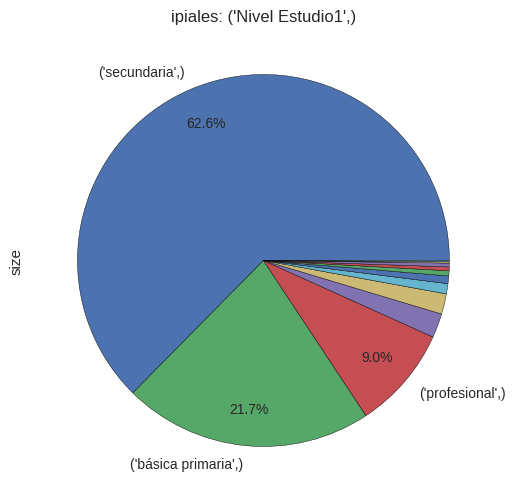

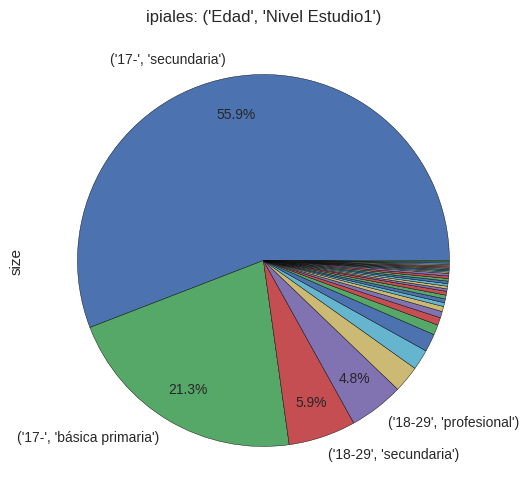

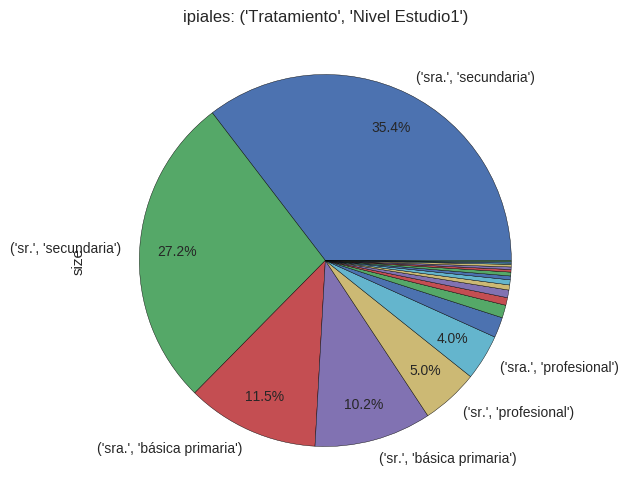

In [93]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

#### Área de estudios

In [94]:
otra_ciudad_df = perfiles_otras_area_df[perfiles_otras_area_df['Ciudad'] == b]

In [95]:
combs = [
    ('Área de Estudio1',), # Grupos de usuarios por área de estudio en la ciudad
    ('Tratamiento', 'Área de Estudio1'), # Grupos de usuarios por sexo y área de estudio en la ciudad
]

In [96]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Área de Estudio1',) 31
('Tratamiento', 'Área de Estudio1') 38
CPU times: user 113 ms, sys: 0 ns, total: 113 ms
Wall time: 112 ms


COMBINATION # 1
GROUP BY: ('Área de Estudio1',)
NUMBER OF GROUPS: 31
TOP 12 LARGEST GROUPS:


(Área de Estudio1,)  size  total percentage
0                        (escolar,)   516    565     91.33%
1               (ing. de sistemas,)     5    565      0.88%
2                        (derecho,)     4    565      0.71%
3               (adm. de empresas,)     3    565      0.53%
4                       (economía,)     3    565      0.53%
5                     (psicología,)     3    565      0.53%
6                   (arquitectura,)     2    565      0.35%
7                     (literatura,)     2    565      0.35%
8                (ing. industrial,)     2    565      0.35%
9                   (adm. pública,)     2    565      0.35%
10  (adm. de empresas comerciales,)     2    565      0.35%
11                    (contaduría,)     2    565      0.35%

COMBINATION # 2
GROUP BY: ('Tratamiento', 'Área de Estudio1')
NUMBER OF GROUPS: 38
TOP 12 LARGEST GROUPS:


(Tratamiento, Área de Estudio1)  size  total percentage
0                       (sra., escolar)   284    565     50.27%
1                        (sr., escolar)   232    565     41.06%
2               (sr., ing. de sistemas)     3    565      0.53%
3               (sr., adm. de empresas)     3    565      0.53%
4                        (sr., derecho)     3    565      0.53%
5              (sra., ing. de sistemas)     2    565      0.35%
6                     (sr., psicología)     2    565      0.35%
7                      (sra., economía)     2    565      0.35%
8   (sr., adm. de empresas comerciales)     2    565      0.35%
9                    (sra., literatura)     2    565      0.35%
10                  (sr., adm. pública)     2    565      0.35%
11                   (sra., contaduría)     2    565      0.35%

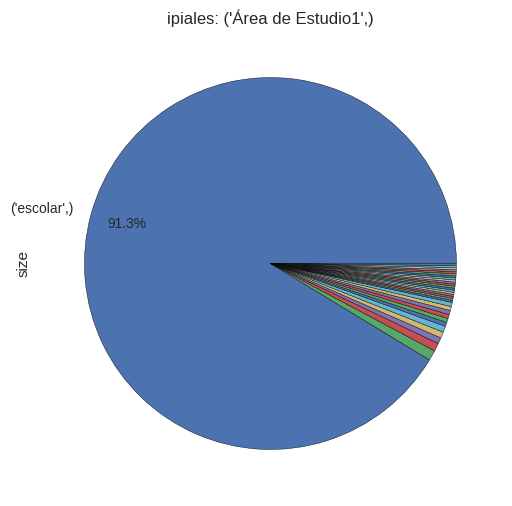

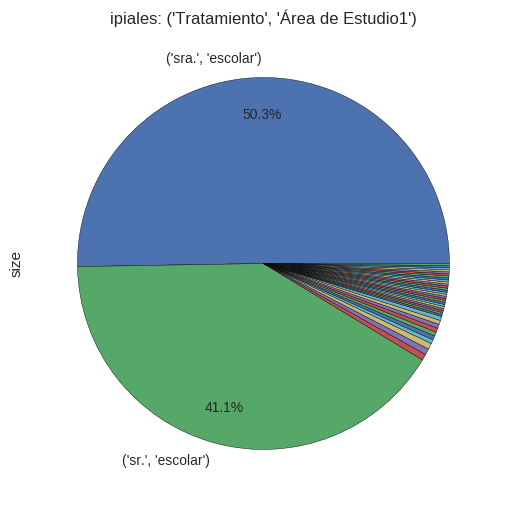

In [97]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

In [98]:
ciudades_counter_df.head(15)

tunja         2970
ibague        2309
popayan       2033
neiva         1787
pereira       1494
manizales     1140
ipiales       1020
girardot       910
cartagena      732
san andres     684
valledupar     651
florencia      607
armenia        495
leticia        491
quibdo         467
Name: Ciudad, dtype: int64

### girardot

In [99]:
b = 'girardot'

#### Nivel de estudios

In [100]:
otra_ciudad_df = perfiles_otras_nivel_df[perfiles_otras_nivel_df['Ciudad'] == b]

In [101]:
combs = [
    ('Nivel Estudio1',), # Grupos de usuarios por nivel de estudio en la ciudad
    ('Edad', 'Nivel Estudio1'), # Grupos de usuarios por edad y nivel de estudio en la ciudad
    ('Tratamiento', 'Nivel Estudio1'), # Grupos de usuarios por sexo y nivel de estudio en la ciudad
]

In [102]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Nivel Estudio1',) 11
('Edad', 'Nivel Estudio1') 35
('Tratamiento', 'Nivel Estudio1') 20
CPU times: user 290 ms, sys: 2.89 ms, total: 292 ms
Wall time: 291 ms


COMBINATION # 1
GROUP BY: ('Nivel Estudio1',)
NUMBER OF GROUPS: 11
TOP 12 LARGEST GROUPS:


(Nivel Estudio1,)  size  total percentage
0              (secundaria,)   410    760     53.95%
1         (básica primaria,)   186    760     24.47%
2   (universitario 1 nivel,)    43    760      5.66%
3                 (técnico,)    40    760      5.26%
4             (profesional,)    40    760      5.26%
5   (universitario 2 nivel,)    22    760      2.89%
6               (postgrado,)     8    760      1.05%
7             (tecnológico,)     7    760      0.92%
8                (maestría,)     2    760      0.26%
9                (graduado,)     1    760      0.13%
10                (ninguno,)     1    760      0.13%

COMBINATION # 2
GROUP BY: ('Edad', 'Nivel Estudio1')
NUMBER OF GROUPS: 35
TOP 12 LARGEST GROUPS:


(Edad, Nivel Estudio1)  size  total percentage
0                (17-, secundaria)   358    760     47.11%
1           (17-, básica primaria)   186    760     24.47%
2              (18-29, secundaria)    34    760      4.47%
3   (18-29, universitario 1 nivel)    33    760      4.34%
4                 (18-29, técnico)    25    760      3.29%
5   (18-29, universitario 2 nivel)    18    760      2.37%
6             (18-29, profesional)    13    760      1.71%
7             (40-49, profesional)     9    760      1.18%
8             (30-39, profesional)     9    760      1.18%
9                (65+, secundaria)     8    760      1.05%
10                (30-39, técnico)     7    760      0.92%
11            (18-29, tecnológico)     7    760      0.92%

COMBINATION # 3
GROUP BY: ('Tratamiento', 'Nivel Estudio1')
NUMBER OF GROUPS: 20
TOP 12 LARGEST GROUPS:


(Tratamiento, Nivel Estudio1)  size  total percentage
0              (sra., secundaria)   236    760     31.05%
1               (sr., secundaria)   174    760     22.89%
2         (sra., básica primaria)   107    760     14.08%
3          (sr., básica primaria)    79    760     10.39%
4                 (sra., técnico)    27    760      3.55%
5   (sra., universitario 1 nivel)    25    760      3.29%
6              (sr., profesional)    21    760      2.76%
7             (sra., profesional)    19    760      2.50%
8    (sr., universitario 1 nivel)    18    760      2.37%
9   (sra., universitario 2 nivel)    15    760      1.97%
10                 (sr., técnico)    13    760      1.71%
11   (sr., universitario 2 nivel)     7    760      0.92%

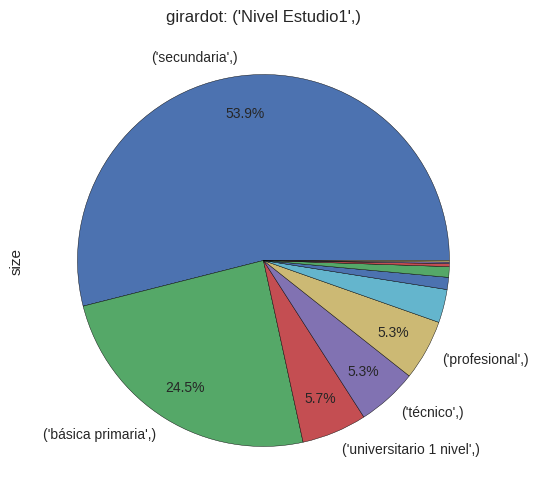

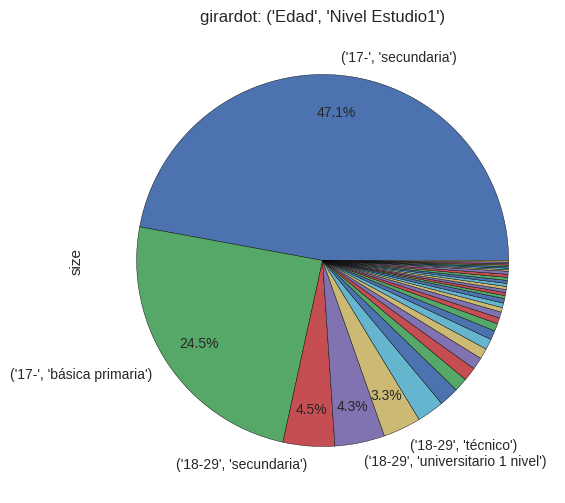

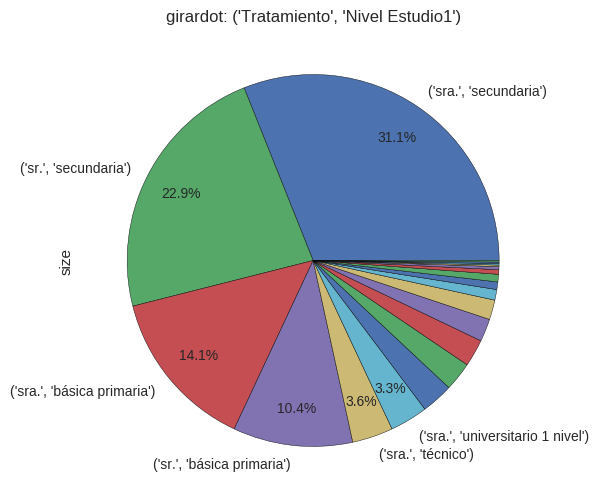

In [103]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

#### Área de estudios

In [104]:
otra_ciudad_df = perfiles_otras_area_df[perfiles_otras_area_df['Ciudad'] == b]

In [105]:
combs = [
    ('Área de Estudio1',), # Grupos de usuarios por área de estudio en la ciudad
    ('Tratamiento', 'Área de Estudio1'), # Grupos de usuarios por sexo y área de estudio en la ciudad
]

In [106]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Área de Estudio1',) 33
('Tratamiento', 'Área de Estudio1') 50
CPU times: user 23.1 ms, sys: 0 ns, total: 23.1 ms
Wall time: 22.1 ms


COMBINATION # 1
GROUP BY: ('Área de Estudio1',)
NUMBER OF GROUPS: 33
TOP 12 LARGEST GROUPS:


(Área de Estudio1,)  size  total percentage
0               (escolar,)    15    109     13.76%
1             (pedagogía,)    13    109     11.93%
2               (derecho,)     8    109      7.34%
3            (ing. civil,)     7    109      6.42%
4      (adm. de empresas,)     6    109      5.50%
5               (idiomas,)     5    109      4.59%
6            (enfermería,)     5    109      4.59%
7        (trabajo social,)     5    109      4.59%
8   (comunicación social,)     4    109      3.67%
9        (ing. ambiental,)     4    109      3.67%
10           (psicología,)     4    109      3.67%
11           (contaduría,)     4    109      3.67%

COMBINATION # 2
GROUP BY: ('Tratamiento', 'Área de Estudio1')
NUMBER OF GROUPS: 50
TOP 12 LARGEST GROUPS:


(Tratamiento, Área de Estudio1)  size  total percentage
0                  (sra., escolar)    12    109     11.01%
1                (sra., pedagogía)    11    109     10.09%
2                (sr., ing. civil)     5    109      4.59%
3                   (sr., derecho)     5    109      4.59%
4         (sra., adm. de empresas)     4    109      3.67%
5               (sra., enfermería)     4    109      3.67%
6           (sra., trabajo social)     3    109      2.75%
7      (sra., comunicación social)     3    109      2.75%
8               (sra., contaduría)     3    109      2.75%
9                   (sr., escolar)     3    109      2.75%
10                 (sra., derecho)     3    109      2.75%
11                 (sra., idiomas)     3    109      2.75%

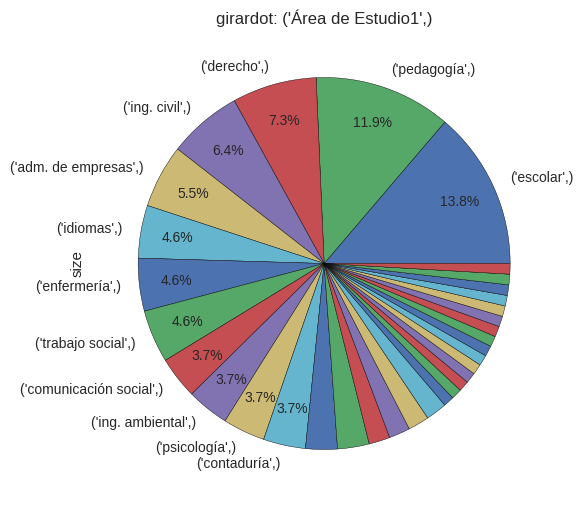

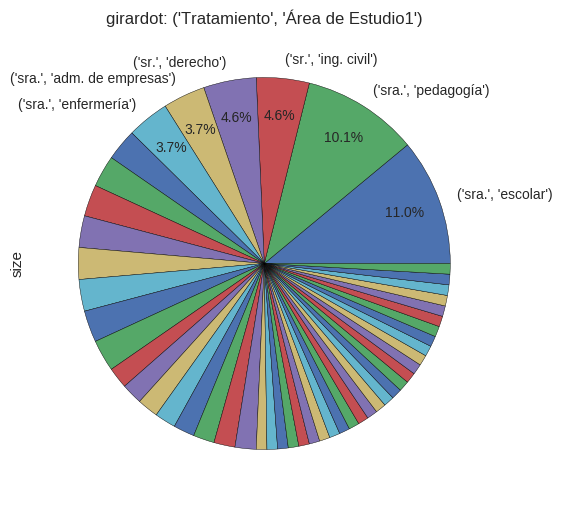

In [107]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

In [108]:
ciudades_counter_df.head(15)

tunja         2970
ibague        2309
popayan       2033
neiva         1787
pereira       1494
manizales     1140
ipiales       1020
girardot       910
cartagena      732
san andres     684
valledupar     651
florencia      607
armenia        495
leticia        491
quibdo         467
Name: Ciudad, dtype: int64

### cartagena

In [109]:
b = 'cartagena'

#### Nivel de estudios

In [110]:
otra_ciudad_df = perfiles_otras_nivel_df[perfiles_otras_nivel_df['Ciudad'] == b]

In [111]:
combs = [
    ('Nivel Estudio1',), # Grupos de usuarios por nivel de estudio en la ciudad
    ('Edad', 'Nivel Estudio1'), # Grupos de usuarios por edad y nivel de estudio en la ciudad
    ('Tratamiento', 'Nivel Estudio1'), # Grupos de usuarios por sexo y nivel de estudio en la ciudad
]

In [112]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Nivel Estudio1',) 11
('Edad', 'Nivel Estudio1') 50
('Tratamiento', 'Nivel Estudio1') 21
CPU times: user 154 ms, sys: 0 ns, total: 154 ms
Wall time: 152 ms


COMBINATION # 1
GROUP BY: ('Nivel Estudio1',)
NUMBER OF GROUPS: 11
TOP 12 LARGEST GROUPS:


(Nivel Estudio1,)  size  total percentage
0   (universitario 2 nivel,)   157    549     28.60%
1   (universitario 1 nivel,)   138    549     25.14%
2             (profesional,)   101    549     18.40%
3         (básica primaria,)    38    549      6.92%
4                (maestría,)    31    549      5.65%
5              (secundaria,)    23    549      4.19%
6               (postgrado,)    20    549      3.64%
7             (tecnológico,)    16    549      2.91%
8                 (técnico,)    13    549      2.37%
9               (doctorado,)    10    549      1.82%
10               (graduado,)     2    549      0.36%

COMBINATION # 2
GROUP BY: ('Edad', 'Nivel Estudio1')
NUMBER OF GROUPS: 50
TOP 12 LARGEST GROUPS:


(Edad, Nivel Estudio1)  size  total percentage
0   (18-29, universitario 2 nivel)   131    549     23.86%
1   (18-29, universitario 1 nivel)   106    549     19.31%
2             (18-29, profesional)    35    549      6.38%
3           (17-, básica primaria)    32    549      5.83%
4             (30-39, profesional)    28    549      5.10%
5     (17-, universitario 1 nivel)    18    549      3.28%
6   (30-39, universitario 2 nivel)    15    549      2.73%
7             (50-64, profesional)    15    549      2.73%
8                (30-39, maestría)    13    549      2.37%
9             (40-49, profesional)    12    549      2.19%
10            (18-29, tecnológico)    11    549      2.00%
11               (17-, secundaria)    11    549      2.00%

COMBINATION # 3
GROUP BY: ('Tratamiento', 'Nivel Estudio1')
NUMBER OF GROUPS: 21
TOP 12 LARGEST GROUPS:


(Tratamiento, Nivel Estudio1)  size  total percentage
0    (sr., universitario 2 nivel)    94    549     17.12%
1   (sra., universitario 1 nivel)    80    549     14.57%
2   (sra., universitario 2 nivel)    63    549     11.48%
3              (sr., profesional)    62    549     11.29%
4    (sr., universitario 1 nivel)    58    549     10.56%
5             (sra., profesional)    39    549      7.10%
6                 (sr., maestría)    23    549      4.19%
7         (sra., básica primaria)    22    549      4.01%
8          (sr., básica primaria)    16    549      2.91%
9               (sr., secundaria)    15    549      2.73%
10               (sr., postgrado)    14    549      2.55%
11                 (sr., técnico)    10    549      1.82%

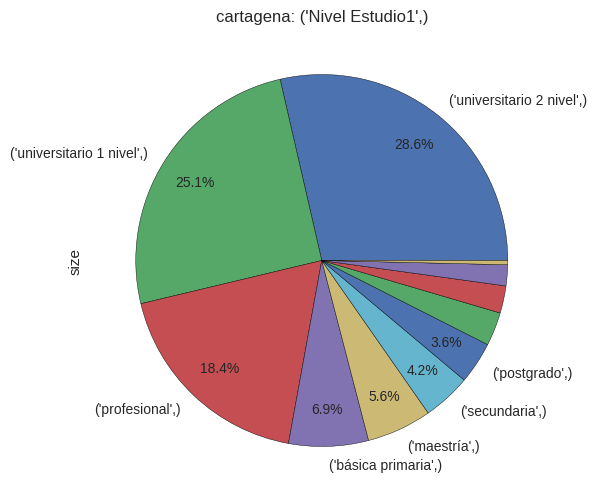

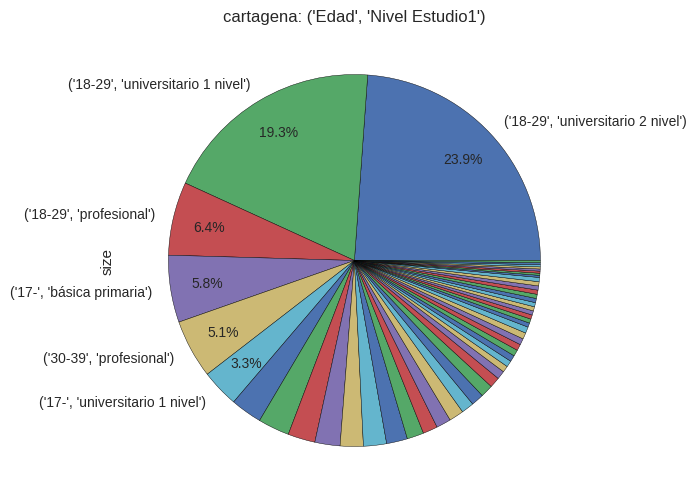

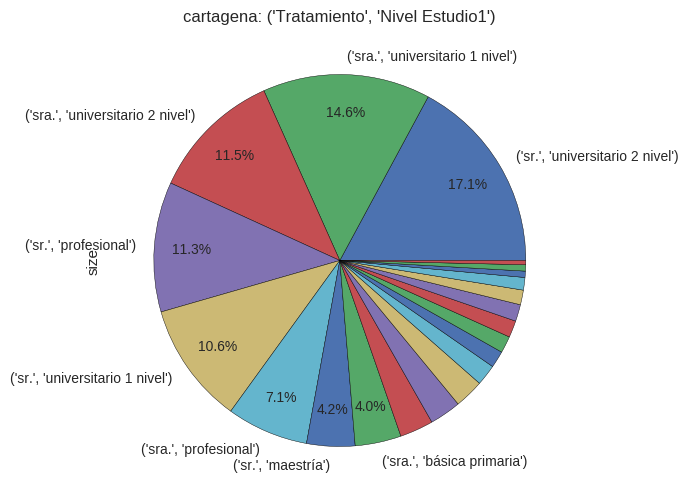

In [113]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

#### Área de estudios

In [114]:
otra_ciudad_df = perfiles_otras_area_df[perfiles_otras_area_df['Ciudad'] == b]

In [115]:
combs = [
    ('Área de Estudio1',), # Grupos de usuarios por área de estudio en la ciudad
    ('Tratamiento', 'Área de Estudio1'), # Grupos de usuarios por sexo y área de estudio en la ciudad
]

In [116]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Área de Estudio1',) 55
('Tratamiento', 'Área de Estudio1') 80
CPU times: user 77.1 ms, sys: 2.27 ms, total: 79.4 ms
Wall time: 78.5 ms


COMBINATION # 1
GROUP BY: ('Área de Estudio1',)
NUMBER OF GROUPS: 55
TOP 12 LARGEST GROUPS:


(Área de Estudio1,)  size  total percentage
0               (derecho,)   104    424     24.53%
1              (historia,)    67    424     15.80%
2              (medicina,)    26    424      6.13%
3            (literatura,)    24    424      5.66%
4    (filosofía y letras,)    22    424      5.19%
5              (economía,)    20    424      4.72%
6      (adm. de empresas,)    13    424      3.07%
7             (pedagogía,)    12    424      2.83%
8   (comunicación social,)    11    424      2.59%
9            (contaduría,)     9    424      2.12%
10       (trabajo social,)     7    424      1.65%
11       (diseño gráfico,)     7    424      1.65%

COMBINATION # 2
GROUP BY: ('Tratamiento', 'Área de Estudio1')
NUMBER OF GROUPS: 80
TOP 12 LARGEST GROUPS:


(Tratamiento, Área de Estudio1)  size  total percentage
0                   (sr., derecho)    59    424     13.92%
1                  (sr., historia)    49    424     11.56%
2                  (sra., derecho)    45    424     10.61%
3                 (sra., historia)    18    424      4.25%
4        (sr., filosofía y letras)    16    424      3.77%
5                 (sra., medicina)    14    424      3.30%
6                  (sr., economía)    13    424      3.07%
7               (sra., literatura)    13    424      3.07%
8                  (sr., medicina)    12    424      2.83%
9                (sr., literatura)    11    424      2.59%
10               (sra., pedagogía)    10    424      2.36%
11     (sra., comunicación social)     8    424      1.89%

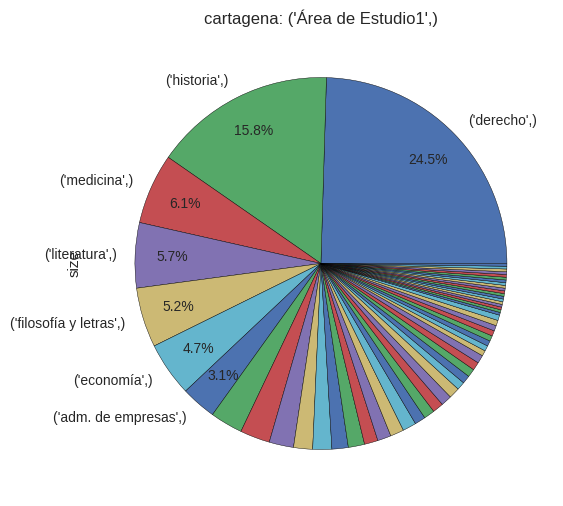

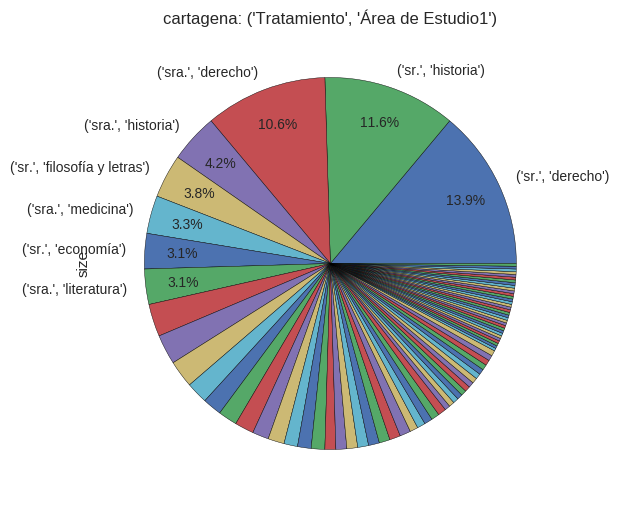

In [117]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

In [118]:
ciudades_counter_df.head(15)

tunja         2970
ibague        2309
popayan       2033
neiva         1787
pereira       1494
manizales     1140
ipiales       1020
girardot       910
cartagena      732
san andres     684
valledupar     651
florencia      607
armenia        495
leticia        491
quibdo         467
Name: Ciudad, dtype: int64

### san andres

In [119]:
b = 'san andres'

#### Nivel de estudios

In [120]:
otra_ciudad_df = perfiles_otras_nivel_df[perfiles_otras_nivel_df['Ciudad'] == b]

In [121]:
combs = [
    ('Nivel Estudio1',), # Grupos de usuarios por nivel de estudio en la ciudad
    ('Edad', 'Nivel Estudio1'), # Grupos de usuarios por edad y nivel de estudio en la ciudad
    ('Tratamiento', 'Nivel Estudio1'), # Grupos de usuarios por sexo y nivel de estudio en la ciudad
]

In [122]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Nivel Estudio1',) 11
('Edad', 'Nivel Estudio1') 26
('Tratamiento', 'Nivel Estudio1') 19
CPU times: user 140 ms, sys: 0 ns, total: 140 ms
Wall time: 138 ms


COMBINATION # 1
GROUP BY: ('Nivel Estudio1',)
NUMBER OF GROUPS: 11
TOP 12 LARGEST GROUPS:


(Nivel Estudio1,)  size  total percentage
0         (básica primaria,)   298    500     59.60%
1              (secundaria,)   147    500     29.40%
2             (profesional,)    29    500      5.80%
3                (maestría,)     7    500      1.40%
4               (postgrado,)     6    500      1.20%
5   (universitario 1 nivel,)     3    500      0.60%
6                 (ninguno,)     3    500      0.60%
7   (universitario 2 nivel,)     2    500      0.40%
8                 (técnico,)     2    500      0.40%
9             (tecnológico,)     2    500      0.40%
10              (doctorado,)     1    500      0.20%

COMBINATION # 2
GROUP BY: ('Edad', 'Nivel Estudio1')
NUMBER OF GROUPS: 26
TOP 12 LARGEST GROUPS:


(Edad, Nivel Estudio1)  size  total percentage
0           (17-, básica primaria)   289    500     57.80%
1                (17-, secundaria)   136    500     27.20%
2             (30-39, profesional)    12    500      2.40%
3           (65+, básica primaria)     8    500      1.60%
4             (18-29, profesional)     7    500      1.40%
5              (18-29, secundaria)     7    500      1.40%
6             (40-49, profesional)     5    500      1.00%
7                (65+, secundaria)     4    500      0.80%
8               (30-39, postgrado)     4    500      0.80%
9                (40-49, maestría)     3    500      0.60%
10              (65+, profesional)     3    500      0.60%
11  (18-29, universitario 1 nivel)     3    500      0.60%

COMBINATION # 3
GROUP BY: ('Tratamiento', 'Nivel Estudio1')
NUMBER OF GROUPS: 19
TOP 12 LARGEST GROUPS:


(Tratamiento, Nivel Estudio1)  size  total percentage
0         (sra., básica primaria)   153    500     30.60%
1          (sr., básica primaria)   145    500     29.00%
2              (sra., secundaria)    86    500     17.20%
3               (sr., secundaria)    61    500     12.20%
4             (sra., profesional)    23    500      4.60%
5              (sr., profesional)     6    500      1.20%
6                (sra., maestría)     6    500      1.20%
7               (sra., postgrado)     5    500      1.00%
8                 (sra., ninguno)     2    500      0.40%
9                 (sra., técnico)     2    500      0.40%
10  (sra., universitario 1 nivel)     2    500      0.40%
11             (sr., tecnológico)     2    500      0.40%

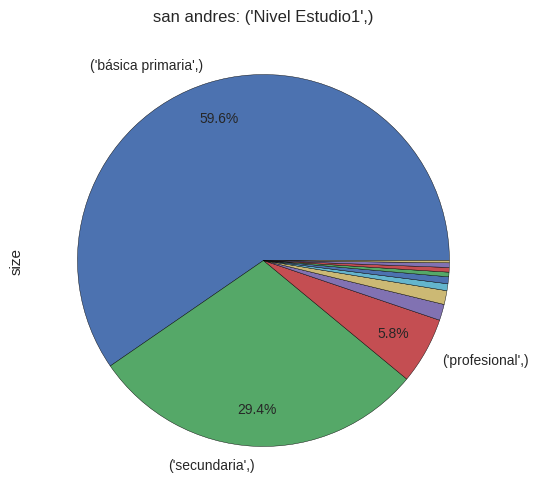

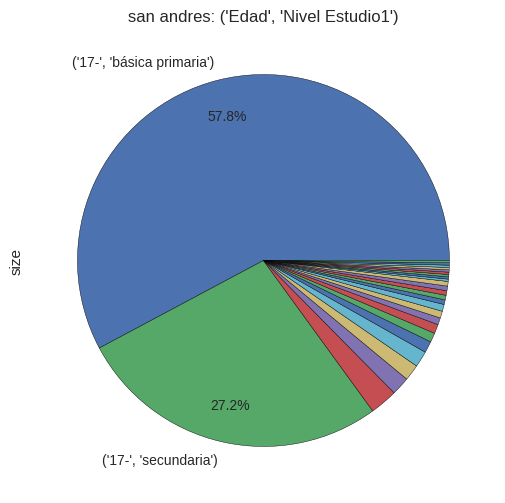

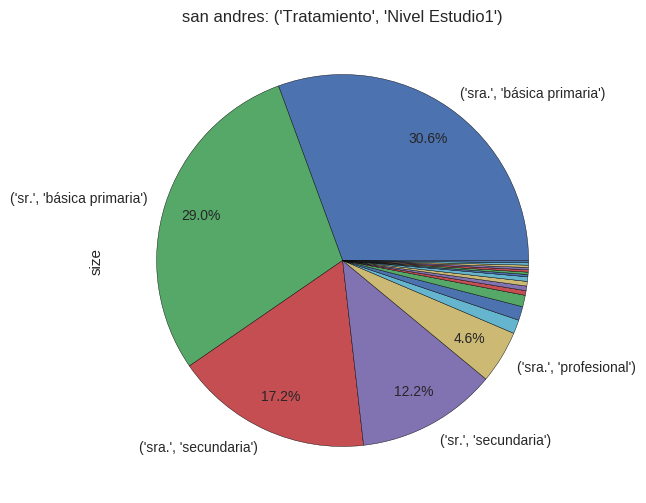

In [123]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

#### Área de estudios

In [124]:
otra_ciudad_df = perfiles_otras_area_df[perfiles_otras_area_df['Ciudad'] == b]

In [125]:
combs = [
    ('Área de Estudio1',), # Grupos de usuarios por área de estudio en la ciudad
    ('Tratamiento', 'Área de Estudio1'), # Grupos de usuarios por sexo y área de estudio en la ciudad
]

In [126]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Área de Estudio1',) 9
('Tratamiento', 'Área de Estudio1') 10
CPU times: user 4.38 ms, sys: 141 µs, total: 4.52 ms
Wall time: 4.34 ms


COMBINATION # 1
GROUP BY: ('Área de Estudio1',)
NUMBER OF GROUPS: 9
TOP 12 LARGEST GROUPS:


(Área de Estudio1,)  size  total percentage
0              (derecho,)     2     10     20.00%
1  (comunicación social,)     1     10     10.00%
2             (economía,)     1     10     10.00%
3       (ing. ambiental,)     1     10     10.00%
4       (adm. educativa,)     1     10     10.00%
5           (literatura,)     1     10     10.00%
6           (psicología,)     1     10     10.00%
7      (biología marina,)     1     10     10.00%
8              (escolar,)     1     10     10.00%

COMBINATION # 2
GROUP BY: ('Tratamiento', 'Área de Estudio1')
NUMBER OF GROUPS: 10
TOP 12 LARGEST GROUPS:


(Tratamiento, Área de Estudio1)  size  total percentage
0                (sra., economía)     1     10     10.00%
1              (sra., literatura)     1     10     10.00%
2          (sra., ing. ambiental)     1     10     10.00%
3          (sr., biología marina)     1     10     10.00%
4                  (sr., escolar)     1     10     10.00%
5     (sra., comunicación social)     1     10     10.00%
6              (sra., psicología)     1     10     10.00%
7                 (sra., derecho)     1     10     10.00%
8                  (sr., derecho)     1     10     10.00%
9          (sra., adm. educativa)     1     10     10.00%

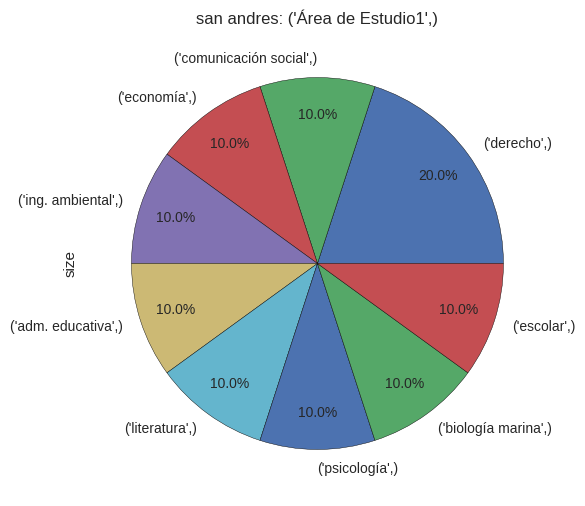

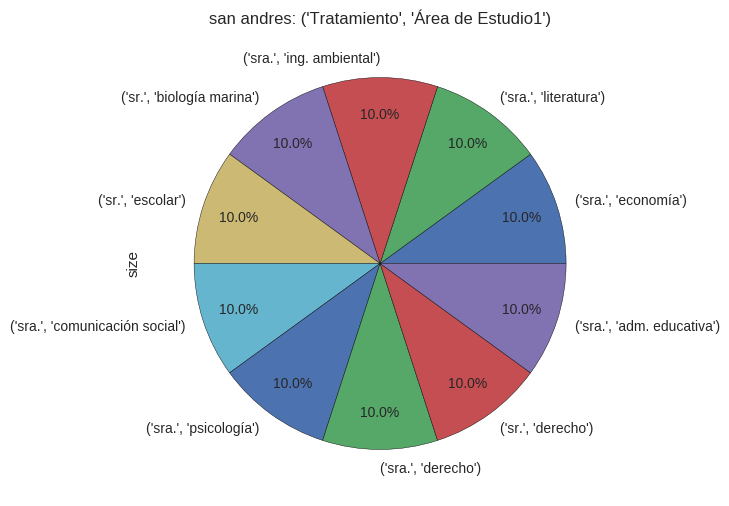

In [127]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

In [128]:
ciudades_counter_df.head(15)

tunja         2970
ibague        2309
popayan       2033
neiva         1787
pereira       1494
manizales     1140
ipiales       1020
girardot       910
cartagena      732
san andres     684
valledupar     651
florencia      607
armenia        495
leticia        491
quibdo         467
Name: Ciudad, dtype: int64

### valledupar

In [129]:
b = 'valledupar'

#### Nivel de estudios

In [130]:
otra_ciudad_df = perfiles_otras_nivel_df[perfiles_otras_nivel_df['Ciudad'] == b]

In [131]:
combs = [
    ('Nivel Estudio1',), # Grupos de usuarios por nivel de estudio en la ciudad
    ('Edad', 'Nivel Estudio1'), # Grupos de usuarios por edad y nivel de estudio en la ciudad
    ('Tratamiento', 'Nivel Estudio1'), # Grupos de usuarios por sexo y nivel de estudio en la ciudad
]

In [132]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Nivel Estudio1',) 11
('Edad', 'Nivel Estudio1') 42
('Tratamiento', 'Nivel Estudio1') 21
CPU times: user 146 ms, sys: 4.3 ms, total: 150 ms
Wall time: 149 ms


COMBINATION # 1
GROUP BY: ('Nivel Estudio1',)
NUMBER OF GROUPS: 11
TOP 12 LARGEST GROUPS:


(Nivel Estudio1,)  size  total percentage
0   (universitario 1 nivel,)   181    518     34.94%
1              (secundaria,)    88    518     16.99%
2   (universitario 2 nivel,)    84    518     16.22%
3         (básica primaria,)    81    518     15.64%
4             (profesional,)    36    518      6.95%
5                (graduado,)    18    518      3.47%
6                 (técnico,)     9    518      1.74%
7                (maestría,)     7    518      1.35%
8             (tecnológico,)     7    518      1.35%
9               (postgrado,)     6    518      1.16%
10              (doctorado,)     1    518      0.19%

COMBINATION # 2
GROUP BY: ('Edad', 'Nivel Estudio1')
NUMBER OF GROUPS: 42
TOP 12 LARGEST GROUPS:


(Edad, Nivel Estudio1)  size  total percentage
0   (18-29, universitario 1 nivel)   158    518     30.50%
1                (17-, secundaria)    80    518     15.44%
2           (17-, básica primaria)    78    518     15.06%
3   (18-29, universitario 2 nivel)    63    518     12.16%
4             (30-39, profesional)    17    518      3.28%
5   (30-39, universitario 1 nivel)    13    518      2.51%
6   (30-39, universitario 2 nivel)    12    518      2.32%
7             (18-29, profesional)    10    518      1.93%
8                 (18-29, técnico)     8    518      1.54%
9     (17-, universitario 1 nivel)     8    518      1.54%
10               (30-39, graduado)     5    518      0.97%
11  (40-49, universitario 2 nivel)     4    518      0.77%

COMBINATION # 3
GROUP BY: ('Tratamiento', 'Nivel Estudio1')
NUMBER OF GROUPS: 21
TOP 12 LARGEST GROUPS:


(Tratamiento, Nivel Estudio1)  size  total percentage
0   (sra., universitario 1 nivel)   112    518     21.62%
1    (sr., universitario 1 nivel)    69    518     13.32%
2              (sra., secundaria)    53    518     10.23%
3   (sra., universitario 2 nivel)    49    518      9.46%
4         (sra., básica primaria)    44    518      8.49%
5          (sr., básica primaria)    37    518      7.14%
6               (sr., secundaria)    35    518      6.76%
7    (sr., universitario 2 nivel)    35    518      6.76%
8             (sra., profesional)    19    518      3.67%
9              (sr., profesional)    17    518      3.28%
10                (sr., graduado)    13    518      2.51%
11                (sra., técnico)     6    518      1.16%

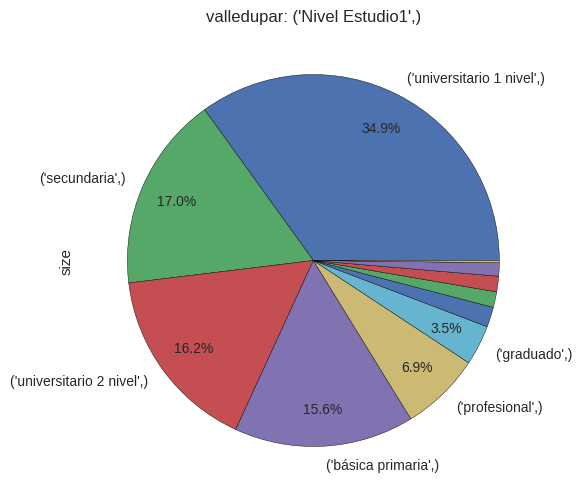

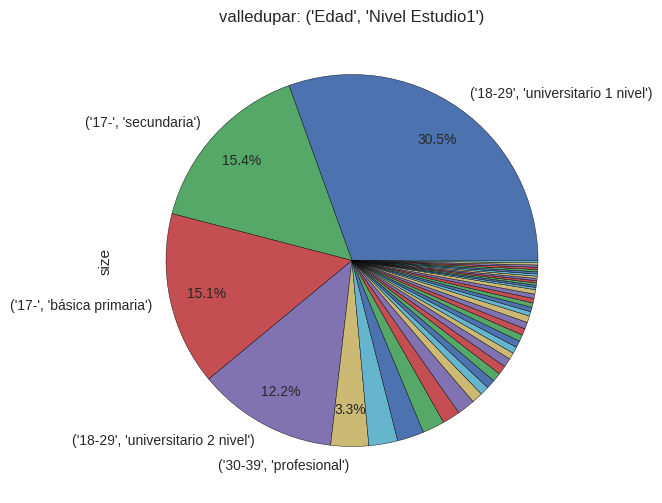

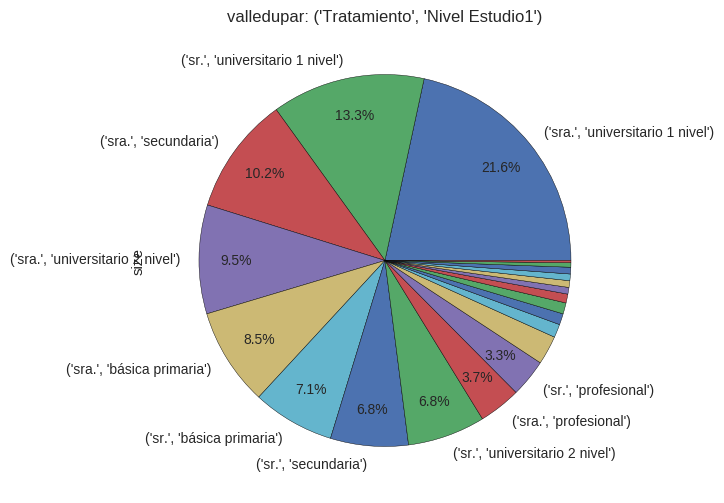

In [133]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

#### Área de estudios

In [134]:
otra_ciudad_df = perfiles_otras_area_df[perfiles_otras_area_df['Ciudad'] == b]

In [135]:
combs = [
    ('Área de Estudio1',), # Grupos de usuarios por área de estudio en la ciudad
    ('Tratamiento', 'Área de Estudio1'), # Grupos de usuarios por sexo y área de estudio en la ciudad
]

In [136]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Área de Estudio1',) 59
('Tratamiento', 'Área de Estudio1') 77
CPU times: user 68.1 ms, sys: 0 ns, total: 68.1 ms
Wall time: 66.6 ms


COMBINATION # 1
GROUP BY: ('Área de Estudio1',)
NUMBER OF GROUPS: 59
TOP 12 LARGEST GROUPS:


(Área de Estudio1,)  size  total percentage
0               (derecho,)    86    326     26.38%
1            (psicología,)    51    326     15.64%
2            (literatura,)    45    326     13.80%
3            (sociología,)    14    326      4.29%
4               (idiomas,)    11    326      3.37%
5            (contaduría,)    10    326      3.07%
6      (adm. de empresas,)     9    326      2.76%
7   (adm. agroindustrial,)     7    326      2.15%
8              (economía,)     6    326      1.84%
9              (medicina,)     5    326      1.53%
10           (ing. civil,)     5    326      1.53%
11           (periodismo,)     4    326      1.23%

COMBINATION # 2
GROUP BY: ('Tratamiento', 'Área de Estudio1')
NUMBER OF GROUPS: 77
TOP 12 LARGEST GROUPS:


(Tratamiento, Área de Estudio1)  size  total percentage
0                   (sr., derecho)    44    326     13.50%
1                  (sra., derecho)    42    326     12.88%
2               (sra., psicología)    40    326     12.27%
3               (sra., literatura)    29    326      8.90%
4                (sr., literatura)    16    326      4.91%
5                (sr., psicología)    11    326      3.37%
6               (sra., sociología)     8    326      2.45%
7         (sra., adm. de empresas)     7    326      2.15%
8                 (sra., economía)     6    326      1.84%
9                (sr., sociología)     6    326      1.84%
10      (sr., adm. agroindustrial)     6    326      1.84%
11                  (sr., idiomas)     6    326      1.84%

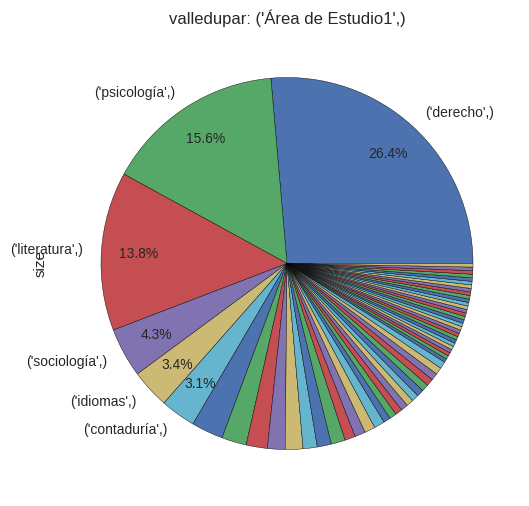

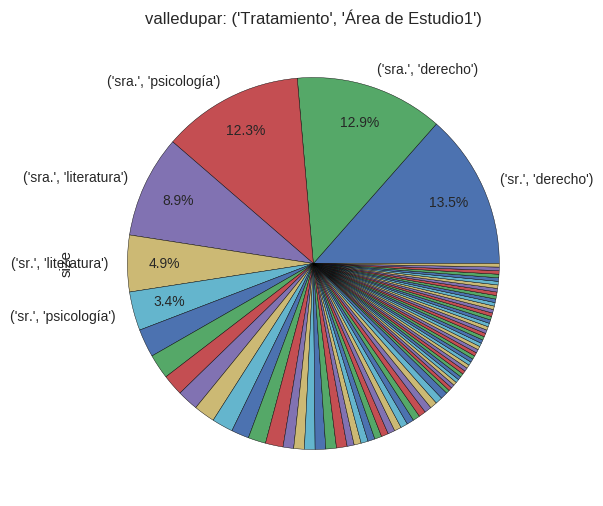

In [137]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

In [138]:
ciudades_counter_df.head(15)

tunja         2970
ibague        2309
popayan       2033
neiva         1787
pereira       1494
manizales     1140
ipiales       1020
girardot       910
cartagena      732
san andres     684
valledupar     651
florencia      607
armenia        495
leticia        491
quibdo         467
Name: Ciudad, dtype: int64

### florencia

In [139]:
b = 'florencia'

#### Nivel de estudios

In [140]:
otra_ciudad_df = perfiles_otras_nivel_df[perfiles_otras_nivel_df['Ciudad'] == b]

In [141]:
combs = [
    ('Nivel Estudio1',), # Grupos de usuarios por nivel de estudio en la ciudad
    ('Edad', 'Nivel Estudio1'), # Grupos de usuarios por edad y nivel de estudio en la ciudad
    ('Tratamiento', 'Nivel Estudio1'), # Grupos de usuarios por sexo y nivel de estudio en la ciudad
]

In [142]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Nivel Estudio1',) 12
('Edad', 'Nivel Estudio1') 33
('Tratamiento', 'Nivel Estudio1') 20
CPU times: user 147 ms, sys: 0 ns, total: 147 ms
Wall time: 146 ms


COMBINATION # 1
GROUP BY: ('Nivel Estudio1',)
NUMBER OF GROUPS: 12
TOP 12 LARGEST GROUPS:


(Nivel Estudio1,)  size  total percentage
0         (básica primaria,)   173    502     34.46%
1              (secundaria,)   162    502     32.27%
2   (universitario 1 nivel,)    55    502     10.96%
3                 (ninguno,)    43    502      8.57%
4   (universitario 2 nivel,)    22    502      4.38%
5             (profesional,)    20    502      3.98%
6               (postgrado,)     9    502      1.79%
7                (maestría,)     7    502      1.39%
8               (doctorado,)     4    502      0.80%
9                 (técnico,)     3    502      0.60%
10               (graduado,)     2    502      0.40%
11            (tecnológico,)     2    502      0.40%

COMBINATION # 2
GROUP BY: ('Edad', 'Nivel Estudio1')
NUMBER OF GROUPS: 33
TOP 12 LARGEST GROUPS:


(Edad, Nivel Estudio1)  size  total percentage
0           (17-, básica primaria)   169    502     33.67%
1                (17-, secundaria)   140    502     27.89%
2                   (17-, ninguno)    43    502      8.57%
3   (18-29, universitario 1 nivel)    35    502      6.97%
4              (18-29, secundaria)    16    502      3.19%
5   (30-39, universitario 1 nivel)    13    502      2.59%
6   (18-29, universitario 2 nivel)    13    502      2.59%
7             (30-39, profesional)     6    502      1.20%
8                (30-39, maestría)     6    502      1.20%
9   (30-39, universitario 2 nivel)     6    502      1.20%
10  (40-49, universitario 1 nivel)     5    502      1.00%
11            (18-29, profesional)     5    502      1.00%

COMBINATION # 3
GROUP BY: ('Tratamiento', 'Nivel Estudio1')
NUMBER OF GROUPS: 20
TOP 12 LARGEST GROUPS:


(Tratamiento, Nivel Estudio1)  size  total percentage
0              (sra., secundaria)    91    502     18.13%
1         (sra., básica primaria)    90    502     17.93%
2          (sr., básica primaria)    83    502     16.53%
3               (sr., secundaria)    71    502     14.14%
4   (sra., universitario 1 nivel)    32    502      6.37%
5    (sr., universitario 1 nivel)    23    502      4.58%
6                  (sr., ninguno)    22    502      4.38%
7                 (sra., ninguno)    21    502      4.18%
8   (sra., universitario 2 nivel)    13    502      2.59%
9              (sr., profesional)    10    502      1.99%
10            (sra., profesional)    10    502      1.99%
11   (sr., universitario 2 nivel)     9    502      1.79%

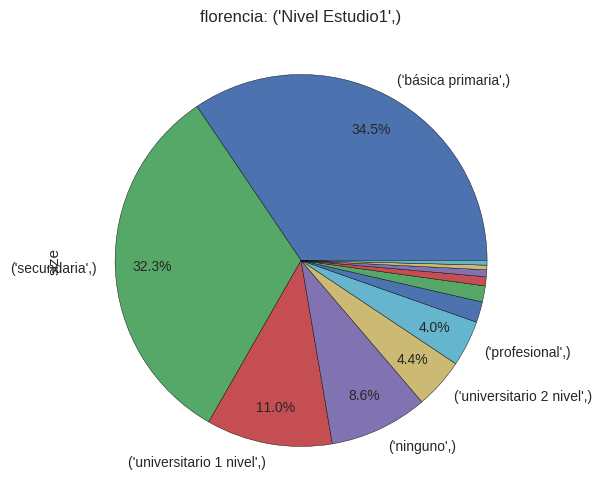

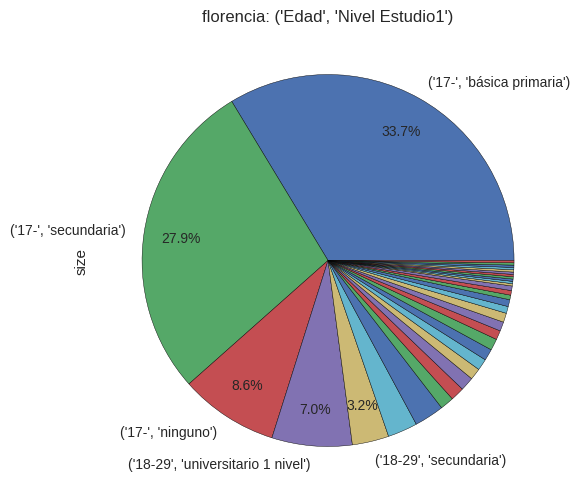

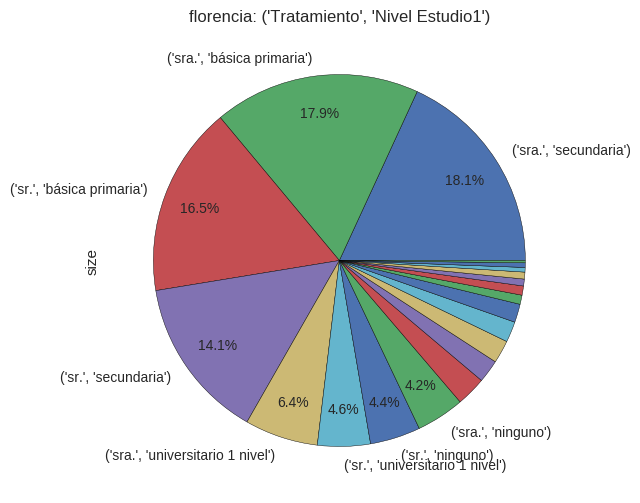

In [143]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

#### Área de estudios

In [144]:
otra_ciudad_df = perfiles_otras_area_df[perfiles_otras_area_df['Ciudad'] == b]

In [145]:
combs = [
    ('Área de Estudio1',), # Grupos de usuarios por área de estudio en la ciudad
    ('Tratamiento', 'Área de Estudio1'), # Grupos de usuarios por sexo y área de estudio en la ciudad
]

In [146]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Área de Estudio1',) 40
('Tratamiento', 'Área de Estudio1') 53
CPU times: user 35 ms, sys: 1.18 ms, total: 36.2 ms
Wall time: 35.5 ms


COMBINATION # 1
GROUP BY: ('Área de Estudio1',)
NUMBER OF GROUPS: 40
TOP 12 LARGEST GROUPS:


(Área de Estudio1,)  size  total percentage
0             (derecho,)    25    108     23.15%
1          (literatura,)    11    108     10.19%
2   (ciencias sociales,)     8    108      7.41%
3         (matemáticas,)     6    108      5.56%
4          (psicología,)     6    108      5.56%
5          (contaduría,)     6    108      5.56%
6             (idiomas,)     3    108      2.78%
7    (adm. de empresas,)     3    108      2.78%
8     (artes escénicas,)     2    108      1.85%
9            (medicina,)     2    108      1.85%
10            (química,)     2    108      1.85%
11       (arquitectura,)     2    108      1.85%

COMBINATION # 2
GROUP BY: ('Tratamiento', 'Área de Estudio1')
NUMBER OF GROUPS: 53
TOP 12 LARGEST GROUPS:


(Tratamiento, Área de Estudio1)  size  total percentage
0                   (sr., derecho)    14    108     12.96%
1                  (sra., derecho)    11    108     10.19%
2               (sra., literatura)     6    108      5.56%
3         (sr., ciencias sociales)     5    108      4.63%
4                (sr., literatura)     5    108      4.63%
5               (sra., contaduría)     4    108      3.70%
6               (sra., psicología)     4    108      3.70%
7               (sr., matemáticas)     3    108      2.78%
8              (sra., matemáticas)     3    108      2.78%
9                  (sra., idiomas)     3    108      2.78%
10       (sra., ciencias sociales)     3    108      2.78%
11                 (sr., medicina)     2    108      1.85%

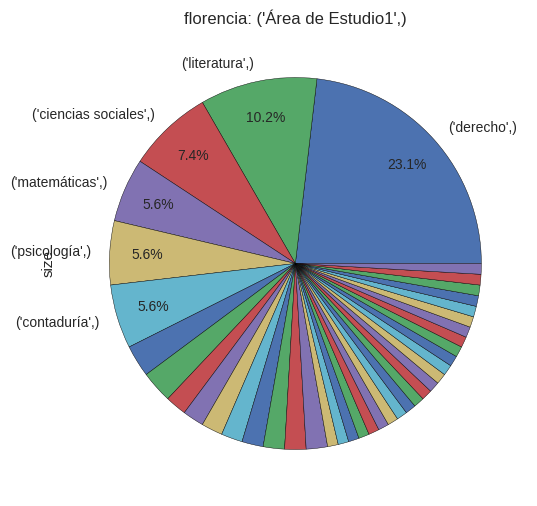

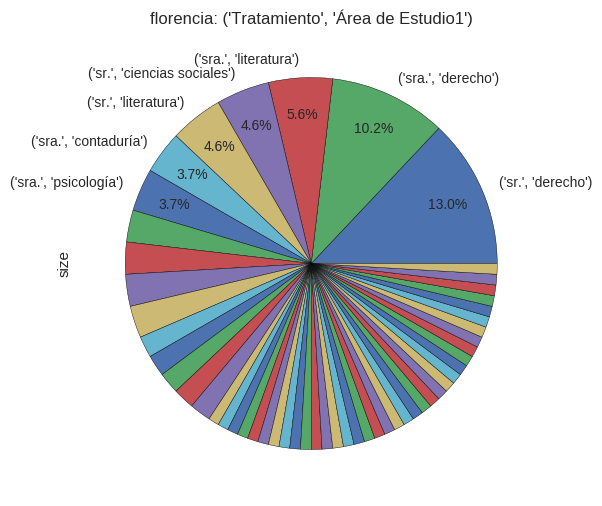

In [147]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

In [148]:
ciudades_counter_df.head(15)

tunja         2970
ibague        2309
popayan       2033
neiva         1787
pereira       1494
manizales     1140
ipiales       1020
girardot       910
cartagena      732
san andres     684
valledupar     651
florencia      607
armenia        495
leticia        491
quibdo         467
Name: Ciudad, dtype: int64

### armenia

In [149]:
b = 'armenia'

#### Nivel de estudios

In [150]:
otra_ciudad_df = perfiles_otras_nivel_df[perfiles_otras_nivel_df['Ciudad'] == b]

In [151]:
combs = [
    ('Nivel Estudio1',), # Grupos de usuarios por nivel de estudio en la ciudad
    ('Edad', 'Nivel Estudio1'), # Grupos de usuarios por edad y nivel de estudio en la ciudad
    ('Tratamiento', 'Nivel Estudio1'), # Grupos de usuarios por sexo y nivel de estudio en la ciudad
]

In [152]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Nivel Estudio1',) 11
('Edad', 'Nivel Estudio1') 25
('Tratamiento', 'Nivel Estudio1') 19
CPU times: user 17.8 ms, sys: 740 µs, total: 18.5 ms
Wall time: 18 ms


COMBINATION # 1
GROUP BY: ('Nivel Estudio1',)
NUMBER OF GROUPS: 11
TOP 12 LARGEST GROUPS:


(Nivel Estudio1,)  size  total percentage
0             (profesional,)    14     57     24.56%
1         (básica primaria,)    12     57     21.05%
2   (universitario 2 nivel,)     8     57     14.04%
3   (universitario 1 nivel,)     6     57     10.53%
4                (maestría,)     5     57      8.77%
5               (postgrado,)     4     57      7.02%
6              (secundaria,)     3     57      5.26%
7               (doctorado,)     2     57      3.51%
8                (graduado,)     1     57      1.75%
9                 (técnico,)     1     57      1.75%
10                (ninguno,)     1     57      1.75%

COMBINATION # 2
GROUP BY: ('Edad', 'Nivel Estudio1')
NUMBER OF GROUPS: 25
TOP 12 LARGEST GROUPS:


(Edad, Nivel Estudio1)  size  total percentage
0           (17-, básica primaria)    12     57     21.05%
1   (18-29, universitario 1 nivel)     5     57      8.77%
2             (30-39, profesional)     5     57      8.77%
3             (50-64, profesional)     4     57      7.02%
4             (18-29, profesional)     4     57      7.02%
5                (17-, secundaria)     3     57      5.26%
6                (40-49, maestría)     3     57      5.26%
7   (30-39, universitario 2 nivel)     2     57      3.51%
8     (65+, universitario 2 nivel)     2     57      3.51%
9   (18-29, universitario 2 nivel)     2     57      3.51%
10              (50-64, postgrado)     1     57      1.75%
11              (18-29, postgrado)     1     57      1.75%

COMBINATION # 3
GROUP BY: ('Tratamiento', 'Nivel Estudio1')
NUMBER OF GROUPS: 19
TOP 12 LARGEST GROUPS:


(Tratamiento, Nivel Estudio1)  size  total percentage
0              (sr., profesional)     9     57     15.79%
1         (sra., básica primaria)     7     57     12.28%
2    (sr., universitario 2 nivel)     5     57      8.77%
3          (sr., básica primaria)     5     57      8.77%
4             (sra., profesional)     5     57      8.77%
5   (sra., universitario 2 nivel)     3     57      5.26%
6   (sra., universitario 1 nivel)     3     57      5.26%
7                 (sr., maestría)     3     57      5.26%
8    (sr., universitario 1 nivel)     3     57      5.26%
9                (sr., postgrado)     2     57      3.51%
10              (sra., postgrado)     2     57      3.51%
11             (sra., secundaria)     2     57      3.51%

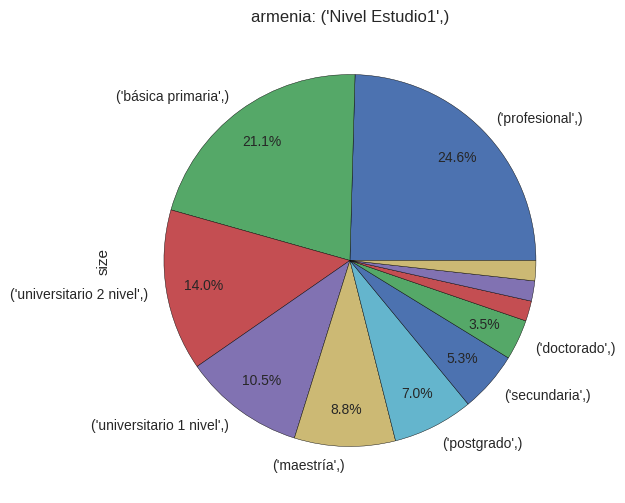

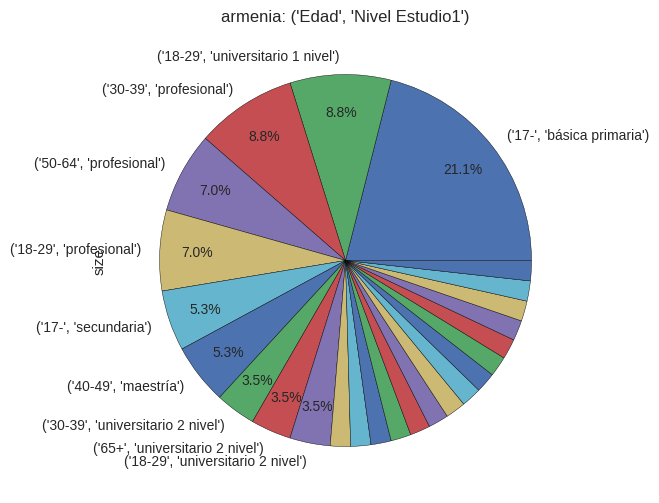

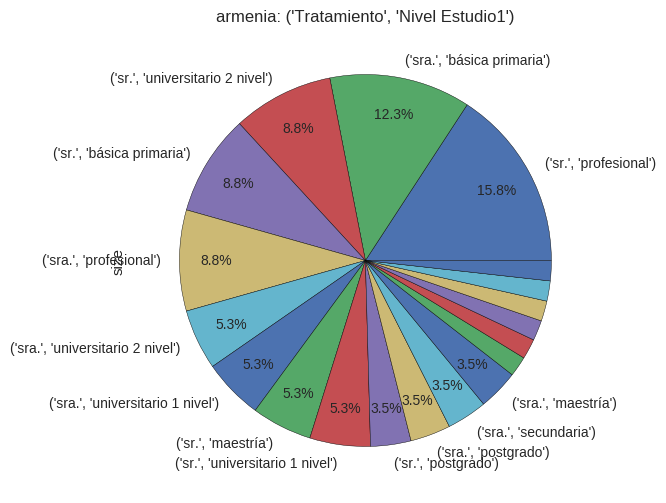

In [153]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

#### Área de estudios

In [154]:
otra_ciudad_df = perfiles_otras_area_df[perfiles_otras_area_df['Ciudad'] == b]

In [155]:
combs = [
    ('Área de Estudio1',), # Grupos de usuarios por área de estudio en la ciudad
    ('Tratamiento', 'Área de Estudio1'), # Grupos de usuarios por sexo y área de estudio en la ciudad
]

In [156]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Área de Estudio1',) 16
('Tratamiento', 'Área de Estudio1') 18
CPU times: user 5.82 ms, sys: 864 µs, total: 6.69 ms
Wall time: 6.35 ms


COMBINATION # 1
GROUP BY: ('Área de Estudio1',)
NUMBER OF GROUPS: 16
TOP 12 LARGEST GROUPS:


(Área de Estudio1,)  size  total percentage
0            (literatura,)     5     26     19.23%
1               (derecho,)     5     26     19.23%
2             (pedagogía,)     2     26      7.69%
3            (psicología,)     2     26      7.69%
4   (comunicación social,)     1     26      3.85%
5              (biología,)     1     26      3.85%
6      (adm. de empresas,)     1     26      3.85%
7       (ing. industrial,)     1     26      3.85%
8              (medicina,)     1     26      3.85%
9            (periodismo,)     1     26      3.85%
10           (preescolar,)     1     26      3.85%
11     (ing. de sistemas,)     1     26      3.85%

COMBINATION # 2
GROUP BY: ('Tratamiento', 'Área de Estudio1')
NUMBER OF GROUPS: 18
TOP 12 LARGEST GROUPS:


(Tratamiento, Área de Estudio1)  size  total percentage
0               (sra., literatura)     5     26     19.23%
1                   (sr., derecho)     3     26     11.54%
2                  (sra., derecho)     2     26      7.69%
3                (sra., pedagogía)     2     26      7.69%
4          (sr., ing. de sistemas)     1     26      3.85%
5        (sr., filosofía y letras)     1     26      3.85%
6                 (sra., biología)     1     26      3.85%
7                  (sr., medicina)     1     26      3.85%
8           (sr., ing. industrial)     1     26      3.85%
9                (sr., psicología)     1     26      3.85%
10      (sr., comunicación social)     1     26      3.85%
11         (sr., adm. de empresas)     1     26      3.85%

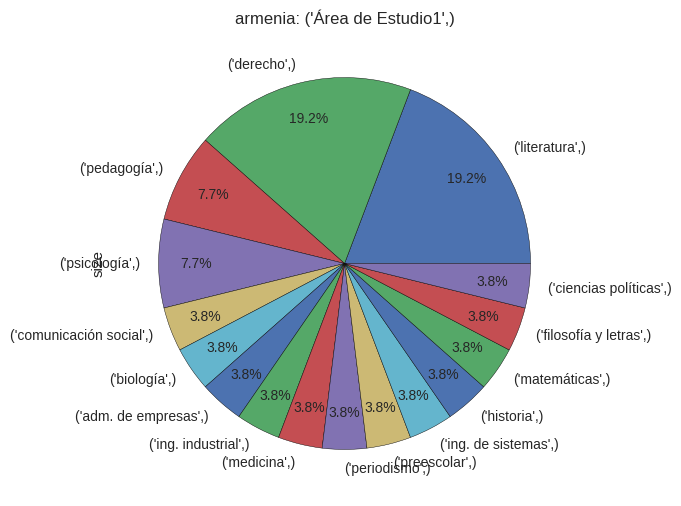

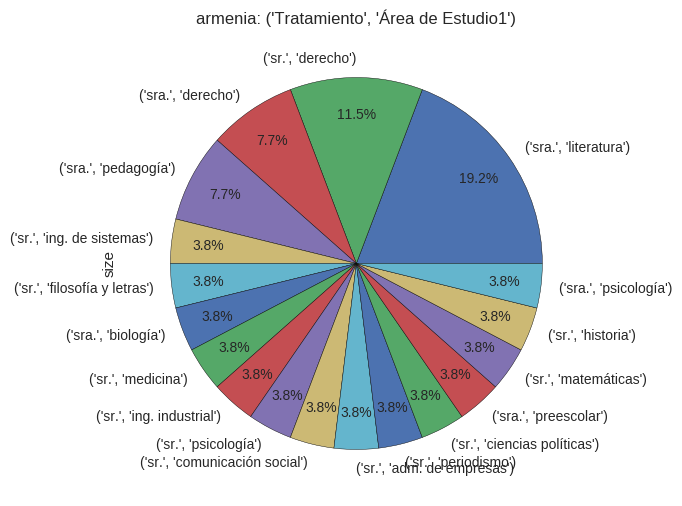

In [157]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

In [158]:
ciudades_counter_df.head(15)

tunja         2970
ibague        2309
popayan       2033
neiva         1787
pereira       1494
manizales     1140
ipiales       1020
girardot       910
cartagena      732
san andres     684
valledupar     651
florencia      607
armenia        495
leticia        491
quibdo         467
Name: Ciudad, dtype: int64

### leticia

In [159]:
b = 'leticia'

#### Nivel de estudios

In [160]:
otra_ciudad_df = perfiles_otras_nivel_df[perfiles_otras_nivel_df['Ciudad'] == b]

In [161]:
combs = [
    ('Nivel Estudio1',), # Grupos de usuarios por nivel de estudio en la ciudad
    ('Edad', 'Nivel Estudio1'), # Grupos de usuarios por edad y nivel de estudio en la ciudad
    ('Tratamiento', 'Nivel Estudio1'), # Grupos de usuarios por sexo y nivel de estudio en la ciudad
]

In [162]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Nivel Estudio1',) 9
('Edad', 'Nivel Estudio1') 20
('Tratamiento', 'Nivel Estudio1') 15
CPU times: user 68.9 ms, sys: 0 ns, total: 68.9 ms
Wall time: 67.5 ms


COMBINATION # 1
GROUP BY: ('Nivel Estudio1',)
NUMBER OF GROUPS: 9
TOP 12 LARGEST GROUPS:


(Nivel Estudio1,)  size  total percentage
0        (básica primaria,)    97    220     44.09%
1             (secundaria,)    88    220     40.00%
2            (profesional,)    14    220      6.36%
3                (ninguno,)     6    220      2.73%
4  (universitario 1 nivel,)     5    220      2.27%
5  (universitario 2 nivel,)     5    220      2.27%
6                (técnico,)     2    220      0.91%
7            (tecnológico,)     2    220      0.91%
8              (postgrado,)     1    220      0.45%

COMBINATION # 2
GROUP BY: ('Edad', 'Nivel Estudio1')
NUMBER OF GROUPS: 20
TOP 12 LARGEST GROUPS:


(Edad, Nivel Estudio1)  size  total percentage
0           (17-, básica primaria)    96    220     43.64%
1                (17-, secundaria)    83    220     37.73%
2                   (17-, ninguno)     6    220      2.73%
3             (30-39, profesional)     5    220      2.27%
4             (18-29, profesional)     4    220      1.82%
5   (18-29, universitario 1 nivel)     4    220      1.82%
6             (40-49, profesional)     3    220      1.36%
7   (30-39, universitario 2 nivel)     3    220      1.36%
8              (18-29, secundaria)     3    220      1.36%
9   (18-29, universitario 2 nivel)     2    220      0.91%
10                (18-29, técnico)     2    220      0.91%
11            (30-39, tecnológico)     1    220      0.45%

COMBINATION # 3
GROUP BY: ('Tratamiento', 'Nivel Estudio1')
NUMBER OF GROUPS: 15
TOP 12 LARGEST GROUPS:


(Tratamiento, Nivel Estudio1)  size  total percentage
0         (sra., básica primaria)    54    220     24.55%
1               (sr., secundaria)    45    220     20.45%
2          (sr., básica primaria)    43    220     19.55%
3              (sra., secundaria)    43    220     19.55%
4              (sr., profesional)     9    220      4.09%
5             (sra., profesional)     5    220      2.27%
6                 (sra., ninguno)     4    220      1.82%
7    (sr., universitario 2 nivel)     3    220      1.36%
8   (sra., universitario 1 nivel)     3    220      1.36%
9   (sra., universitario 2 nivel)     2    220      0.91%
10            (sra., tecnológico)     2    220      0.91%
11                (sra., técnico)     2    220      0.91%

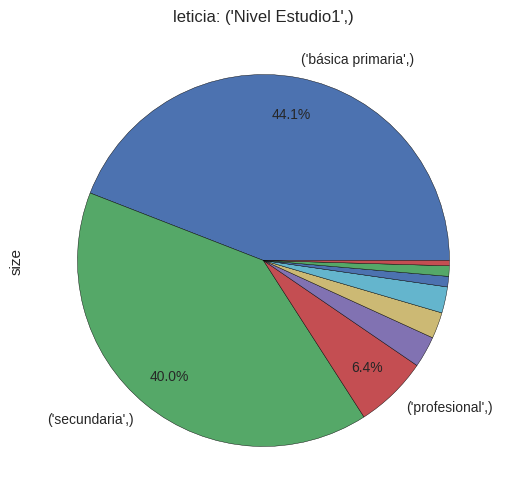

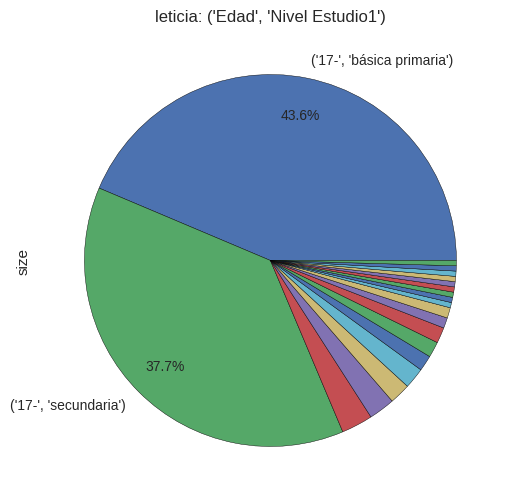

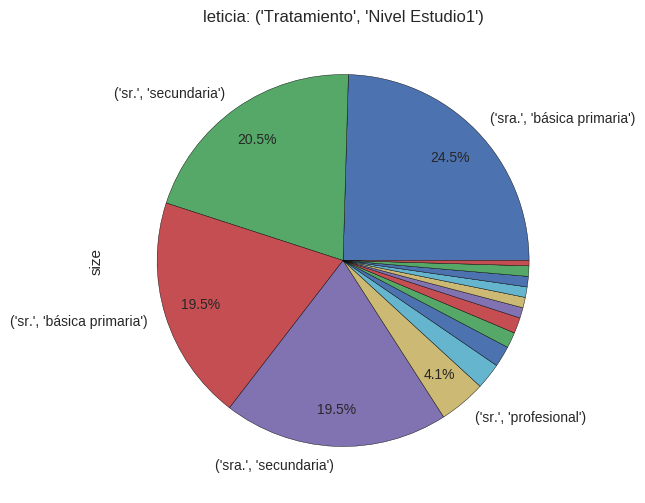

In [163]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

#### Área de estudios

In [164]:
otra_ciudad_df = perfiles_otras_area_df[perfiles_otras_area_df['Ciudad'] == b]

In [165]:
combs = [
    ('Área de Estudio1',), # Grupos de usuarios por área de estudio en la ciudad
    ('Tratamiento', 'Área de Estudio1'), # Grupos de usuarios por sexo y área de estudio en la ciudad
]

In [166]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Área de Estudio1',) 9
('Tratamiento', 'Área de Estudio1') 9
CPU times: user 4.44 ms, sys: 190 µs, total: 4.63 ms
Wall time: 4.26 ms


COMBINATION # 1
GROUP BY: ('Área de Estudio1',)
NUMBER OF GROUPS: 9
TOP 12 LARGEST GROUPS:


(Área de Estudio1,)  size  total percentage
0                       (derecho,)     3     13     23.08%
1                  (antropología,)     2     13     15.38%
2  (adm. de empresas comerciales,)     2     13     15.38%
3    (adm. hotelera y de turismo,)     1     13      7.69%
4             (ciencias sociales,)     1     13      7.69%
5                      (historia,)     1     13      7.69%
6                    (psicología,)     1     13      7.69%
7                      (biología,)     1     13      7.69%
8                (trabajo social,)     1     13      7.69%

COMBINATION # 2
GROUP BY: ('Tratamiento', 'Área de Estudio1')
NUMBER OF GROUPS: 9
TOP 12 LARGEST GROUPS:


(Tratamiento, Área de Estudio1)  size  total percentage
0                       (sr., derecho)     3     13     23.08%
1  (sr., adm. de empresas comerciales)     2     13     15.38%
2                  (sr., antropología)     2     13     15.38%
3                      (sr., biología)     1     13      7.69%
4                (sr., trabajo social)     1     13      7.69%
5   (sra., adm. hotelera y de turismo)     1     13      7.69%
6                   (sra., psicología)     1     13      7.69%
7                      (sr., historia)     1     13      7.69%
8            (sra., ciencias sociales)     1     13      7.69%

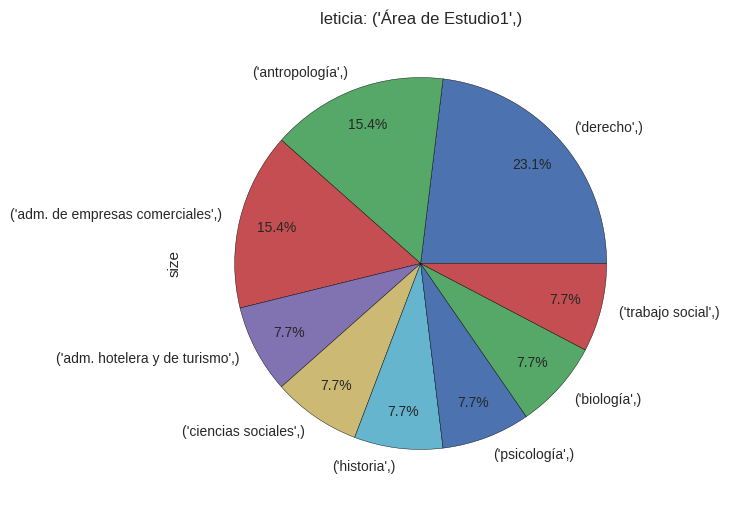

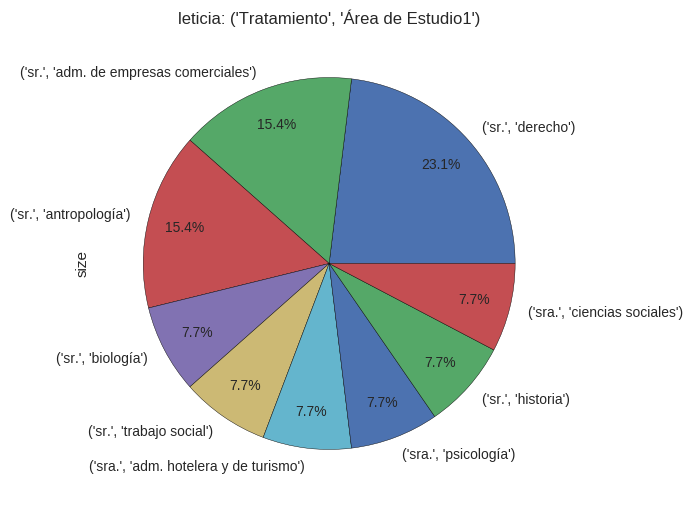

In [167]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

In [168]:
ciudades_counter_df.head(15)

tunja         2970
ibague        2309
popayan       2033
neiva         1787
pereira       1494
manizales     1140
ipiales       1020
girardot       910
cartagena      732
san andres     684
valledupar     651
florencia      607
armenia        495
leticia        491
quibdo         467
Name: Ciudad, dtype: int64

### quibdo

In [169]:
b = 'quibdo'

#### Nivel de estudios

In [170]:
otra_ciudad_df = perfiles_otras_nivel_df[perfiles_otras_nivel_df['Ciudad'] == b]

In [171]:
combs = [
    ('Nivel Estudio1',), # Grupos de usuarios por nivel de estudio en la ciudad
    ('Edad', 'Nivel Estudio1'), # Grupos de usuarios por edad y nivel de estudio en la ciudad
    ('Tratamiento', 'Nivel Estudio1'), # Grupos de usuarios por sexo y nivel de estudio en la ciudad
]

In [172]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Nivel Estudio1',) 9
('Edad', 'Nivel Estudio1') 20
('Tratamiento', 'Nivel Estudio1') 14
CPU times: user 55.1 ms, sys: 1.17 ms, total: 56.3 ms
Wall time: 54.7 ms


COMBINATION # 1
GROUP BY: ('Nivel Estudio1',)
NUMBER OF GROUPS: 9
TOP 12 LARGEST GROUPS:


(Nivel Estudio1,)  size  total percentage
0             (secundaria,)    99    181     54.70%
1  (universitario 1 nivel,)    60    181     33.15%
2  (universitario 2 nivel,)     5    181      2.76%
3                (ninguno,)     5    181      2.76%
4                (técnico,)     4    181      2.21%
5               (graduado,)     3    181      1.66%
6        (básica primaria,)     2    181      1.10%
7            (tecnológico,)     2    181      1.10%
8            (profesional,)     1    181      0.55%

COMBINATION # 2
GROUP BY: ('Edad', 'Nivel Estudio1')
NUMBER OF GROUPS: 20
TOP 12 LARGEST GROUPS:


(Edad, Nivel Estudio1)  size  total percentage
0                (17-, secundaria)    80    181     44.20%
1   (18-29, universitario 1 nivel)    51    181     28.18%
2              (18-29, secundaria)    19    181     10.50%
3     (17-, universitario 1 nivel)     5    181      2.76%
4                   (17-, ninguno)     4    181      2.21%
5   (30-39, universitario 1 nivel)     3    181      1.66%
6                 (18-29, técnico)     3    181      1.66%
7   (30-39, universitario 2 nivel)     2    181      1.10%
8   (18-29, universitario 2 nivel)     2    181      1.10%
9           (17-, básica primaria)     2    181      1.10%
10  (40-49, universitario 1 nivel)     1    181      0.55%
11            (40-49, profesional)     1    181      0.55%

COMBINATION # 3
GROUP BY: ('Tratamiento', 'Nivel Estudio1')
NUMBER OF GROUPS: 14
TOP 12 LARGEST GROUPS:


(Tratamiento, Nivel Estudio1)  size  total percentage
0              (sra., secundaria)    75    181     41.44%
1   (sra., universitario 1 nivel)    52    181     28.73%
2               (sr., secundaria)    24    181     13.26%
3    (sr., universitario 1 nivel)     8    181      4.42%
4   (sra., universitario 2 nivel)     5    181      2.76%
5                 (sra., técnico)     4    181      2.21%
6                  (sr., ninguno)     3    181      1.66%
7                (sra., graduado)     2    181      1.10%
8             (sra., tecnológico)     2    181      1.10%
9                 (sra., ninguno)     2    181      1.10%
10        (sra., básica primaria)     1    181      0.55%
11            (sra., profesional)     1    181      0.55%

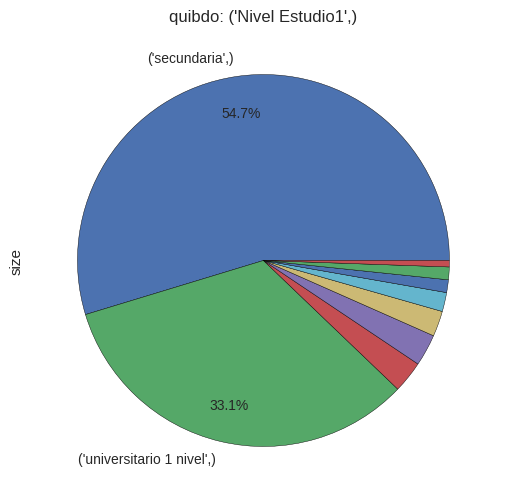

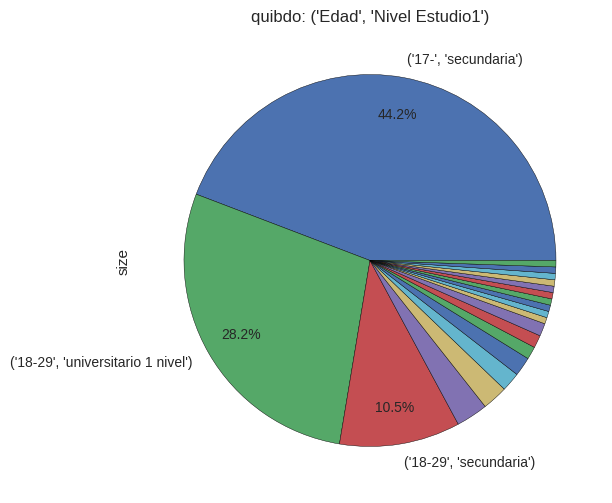

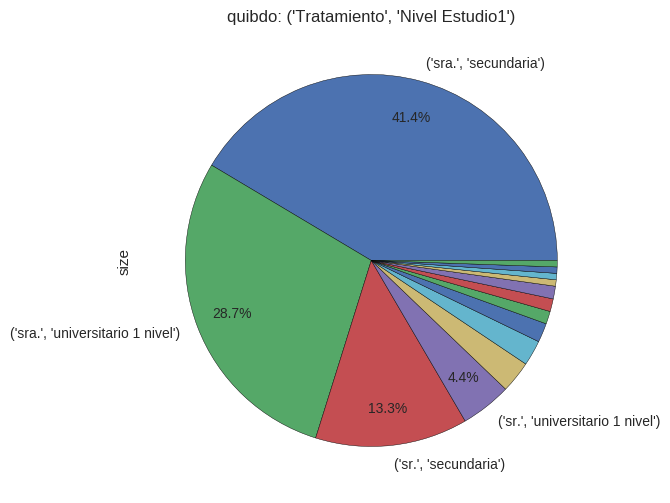

In [173]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))

#### Área de estudios

In [174]:
otra_ciudad_df = perfiles_otras_area_df[perfiles_otras_area_df['Ciudad'] == b]

In [175]:
combs = [
    ('Área de Estudio1',), # Grupos de usuarios por área de estudio en la ciudad
    ('Tratamiento', 'Área de Estudio1'), # Grupos de usuarios por sexo y área de estudio en la ciudad
]

In [176]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = otra_ciudad_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows()]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Área de Estudio1',) 10
('Tratamiento', 'Área de Estudio1') 12
CPU times: user 11.7 ms, sys: 0 ns, total: 11.7 ms
Wall time: 11.2 ms


COMBINATION # 1
GROUP BY: ('Área de Estudio1',)
NUMBER OF GROUPS: 10
TOP 12 LARGEST GROUPS:


(Área de Estudio1,)  size  total percentage
0                     (derecho,)    22     46     47.83%
1                  (contaduría,)     5     46     10.87%
2                  (psicología,)     4     46      8.70%
3                  (enfermería,)     4     46      8.70%
4            (ing. de sistemas,)     3     46      6.52%
5                  (ing. civil,)     2     46      4.35%
6            (adm. de empresas,)     2     46      4.35%
7                   (pedagogía,)     2     46      4.35%
8                (arquitectura,)     1     46      2.17%
9  (ciencias de la información,)     1     46      2.17%

COMBINATION # 2
GROUP BY: ('Tratamiento', 'Área de Estudio1')
NUMBER OF GROUPS: 12
TOP 12 LARGEST GROUPS:


(Tratamiento, Área de Estudio1)  size  total percentage
0                      (sra., derecho)    19     46     41.30%
1                   (sra., contaduría)     5     46     10.87%
2                   (sra., enfermería)     4     46      8.70%
3                   (sra., psicología)     4     46      8.70%
4                       (sr., derecho)     3     46      6.52%
5                    (sra., pedagogía)     2     46      4.35%
6             (sra., adm. de empresas)     2     46      4.35%
7                   (sra., ing. civil)     2     46      4.35%
8             (sra., ing. de sistemas)     2     46      4.35%
9              (sr., ing. de sistemas)     1     46      2.17%
10                (sra., arquitectura)     1     46      2.17%
11  (sra., ciencias de la información)     1     46      2.17%

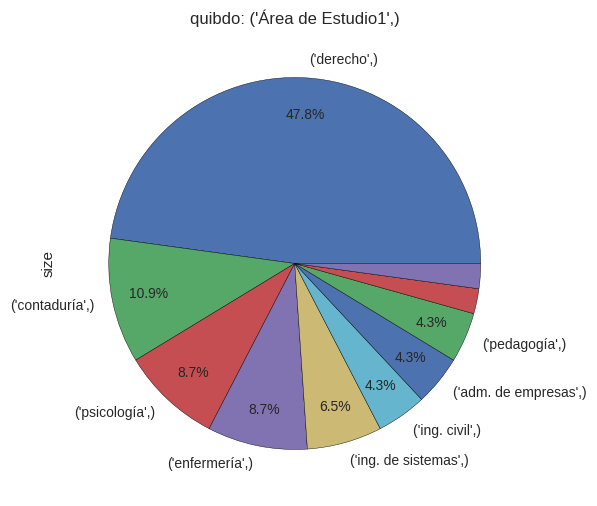

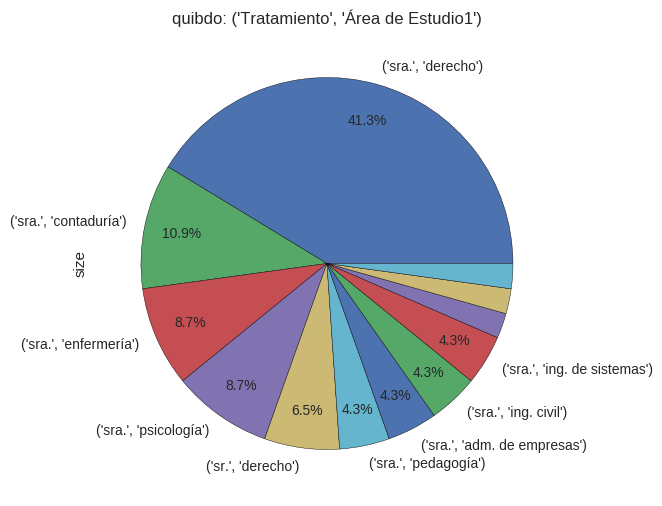

In [177]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct + 0.01 >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(
        kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=b + ': ' + str(k))